In [39]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import DataHandler, open_da, data_path, compute_anomalies_pl, coarsen_da, compute_anomalies_ds
from jetutils.definitions import (
    DATADIR,
    FIGURES,
    PRETTIER_VARNAME,
    YEARS,
    compute,
    get_region,
    infer_direction,
    polars_to_xarray,
    xarray_to_polars,
    labels_to_mask,
    extract_season_from_df,
    DUNCANS_REGIONS_NAMES,
    UNITS,
    N_WORKERS
)
from jetutils.jet_finding import JetFindingExperiment, jet_integral_haversine, find_all_jets, haversine_from_dl
from jetutils.plots import COLORS, COLORS_EXT, PINKPURPLE, Clusterplot, gather_normal_da_jets_wrapper, _gather_normal_da_jets_wrapper, make_transparent
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pathlib import Path

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/6"))
dh_low = DataHandler.from_specs(
    "ERA5", "plev", "mid_wind", "6H", "all", None, -80, 40, 15, 80, "all"
)
ds = exp.ds
all_jets_one_df = exp.find_jets()
all_jets_one_df = exp.categorize_jets(dh_low.da["s"])
props_as_df_uncat = exp.props_as_df(False)
jet_pos_da = exp.jet_position_as_da()
props_as_df = exp.props_as_df(True)

exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/2"))
da_s = exp_s.da
da_s = da_s.sel(time=da_s.time.dt.hour == 0)

ds_ = ds.sel(time=ds.time.dt.hour == 0)
ds_ = ds_.sel(time=ds_.time.dt.season == "JJA")
all_jets_one_df = all_jets_one_df.cast({"time": pl.Datetime("ms")})
all_jets_one_df = all_jets_one_df.with_columns(
    (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5)
    .cast(pl.Int8)
    .alias("jet ID")
)
all_jets_one_df = all_jets_one_df.sort("time", "jet ID", "lon")

In [4]:
da_T = open_da(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    "all",
    "JJA",
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_T = compute(da_T, progress_flag=True)
da_tp = open_da(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    "all",
    "JJA",
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_tp = compute(da_tp, progress_flag=True)
da_apvs = open_da(
    "ERA5",
    "thetalev",
    "apvs",
    "dailyany",
    "all",
    "JJA",
    *get_region(ds),
    "all",
)
da_apvs = compute(da_apvs, progress_flag=True)
da_cpvs = open_da(
    "ERA5",
    "thetalev",
    "cpvs",
    "dailyany",
    "all",
    "JJA",
    *get_region(ds),
    "all",
)
da_cpvs = compute(da_cpvs, progress_flag=True)
da_z = open_da(
    "ERA5",
    "plev",
    "z",
    "dailymean",
    "all",
    "JJA",
    *get_region(ds),
    500,
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_z = compute(da_z, progress_flag=True)

[########################################] | 100% Completed | 27.38 s
[########################################] | 100% Completed | 25.58 s
[########################################] | 100% Completed | 5.44 sms
[########################################] | 100% Completed | 7.15 ss
[########################################] | 100% Completed | 51.63 s


# Define all jet spells once

In [46]:
spells_from_jet_daily_stj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    jet="STJ",
    season="JJA",
    q=0.7,
    daily=True,
    minlen=datetime.timedelta(days=5),
    fill_holes=datetime.timedelta(hours=12),
)
spells_from_jet_daily_edj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    jet="EDJ",
    season="JJA",
    q=0.70,
    daily=True,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=12),
)
spells_list = {
    "STJ adv. spe": spells_from_jet_daily_stj_cs,
    "EDJ adv. spe": spells_from_jet_daily_edj_cs,
}
for na, spells_ in spells_list.items():
    print(na, spells_["spell"].max())

spells_from_jet_daily_stj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    jet="STJ",
    season="JJA",
    q=0.7,
    daily=True,
    minlen=datetime.timedelta(days=5),
    fill_holes=datetime.timedelta(hours=12),
    time_before=datetime.timedelta(days=4),
)
spells_from_jet_daily_edj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    jet="EDJ",
    season="JJA",
    q=0.70,
    daily=True,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=12),
    time_before=datetime.timedelta(days=4),
)
spells_list_time_before = {
    "STJ adv. spe": spells_from_jet_daily_stj_cs,
    "EDJ adv. spe": spells_from_jet_daily_edj_cs,
}

STJ adv. spe 25
EDJ adv. spe 18


# compare with SOM persistence

In [22]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):
    labels = labels.cast({"time": pl.Datetime("ms")})
    summer_cluster = (
        labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    )
    seasons = (
        labels.group_by(pl.col("time").dt.year().alias("year"))
        .agg(
            pl.col("time")
            .get((pl.col("labels") == summer_cluster).arg_true().first())
            .alias("start"),
            pl.col("time")
            .get((pl.col("labels") == summer_cluster).arg_true().last())
            .alias("end"),
        )
        .with_columns(
            spring=pl.datetime_ranges(
                pl.col("start") - datetime.timedelta(days=len_spring),
                pl.col("start"),
                "6h",
            ),
            summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
            autumn=pl.datetime_ranges(
                pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"
            ),
        )
        .drop("year", "start", "end")
    )
    return [seasons[season].explode().sort() for season in seasons.columns]


dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)
da_summer = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(
    exp_wind.path.parent, da_summer, save_da=True
)
exp_summer = Experiment(dh_summer)
nx, ny, n_pca = 4, 4, 200
net, centers, labels = exp_summer.som_cluster(
    nx,
    ny,
    n_pca,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(net.weights)
spells = get_persistent_spell_times_from_som(
    labels, dists, 0, 24, nt_before=20, nojune=True, daily=True
)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})

labels_daily = labels.sel(time=labels.time.dt.hour == 0)
mask_daily = labels_to_mask(labels_daily)
jets_daily = all_jets_one_df.filter(pl.col("time").is_in(summer_daily))

spells_per_cluster = (
    spells.filter(pl.col("relative_index") == 0).group_by("value").len()
)
spells_per_cluster = (
    pl.Series("value", np.arange(net.n_nodes))
    .to_frame()
    .join(spells_per_cluster, how="left", on="value")
    .fill_null(0)
)
numbering = [
    f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in range(net.n_nodes)
]

props_as_df_anoms = compute_anomalies_pl(props_as_df, ("jet",), 31, True)
props_masked = mask_from_spells_pl(
    spells, props_as_df_anoms, time_before=datetime.timedelta(days=5)
)
props_masked_ = (
    props_masked.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet"))
    .mean()
    .rename({"value": "cluster"})
)
indexer = (
    pl.Series("cluster", np.arange(net.n_nodes))
    .to_frame()
    .join(
        props_masked[:, ["jet", "relative_index"]].unique(("jet", "relative_index")),
        how="cross",
    )
    .sort("cluster", "jet", "relative_index")
)
props_masked_ = indexer.join(
    props_masked_, how="left", on=["cluster", "jet", "relative_index"]
)
spells_list[f"SOM"] = spells
spells_list_extended = spells_list.copy()
for cluster in range(net.n_nodes):
    spells_list_extended[f"SOM cluster {cluster}"] = spells.filter(
        pl.col("value") == cluster
    )

In [23]:
file_errors_location = f"{DATADIR}/ERA5/heatwaves_duncan/heatwaves_duncan.xlsx"
df = pl.read_excel(file_errors_location)
for i in range(1, 7):
    dates = f"dates{i}"
    duration = f"duration{i}"
    df_ = df[[duration, dates]].filter(pl.col(duration) > 3)
    df_ = df_.with_columns(
        start=pl.col(dates).str.split("/").list.get(0).str.strptime(pl.Datetime),
        end=pl.col(dates).str.split("/").list.get(1).str.strptime(pl.Datetime),
    )
    df_ = df_.with_columns(time=pl.date_ranges(pl.col("start"), pl.col("end")))
    df_ = df_.drop(dates, duration, "start", "end")
    df_ = df_.with_row_index(name="spell").explode("time")
    spells_list[DUNCANS_REGIONS_NAMES[i - 1]] = df_
    spells_list_extended[DUNCANS_REGIONS_NAMES[i - 1]] = df_

25
18
161
36
48
53
63
44
46


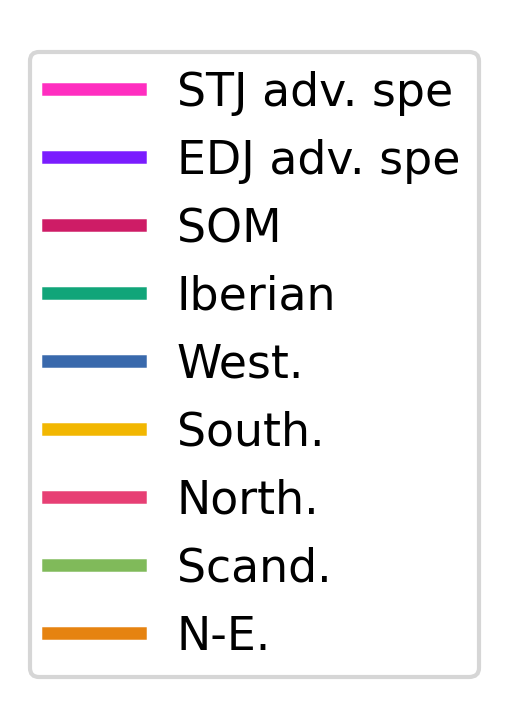

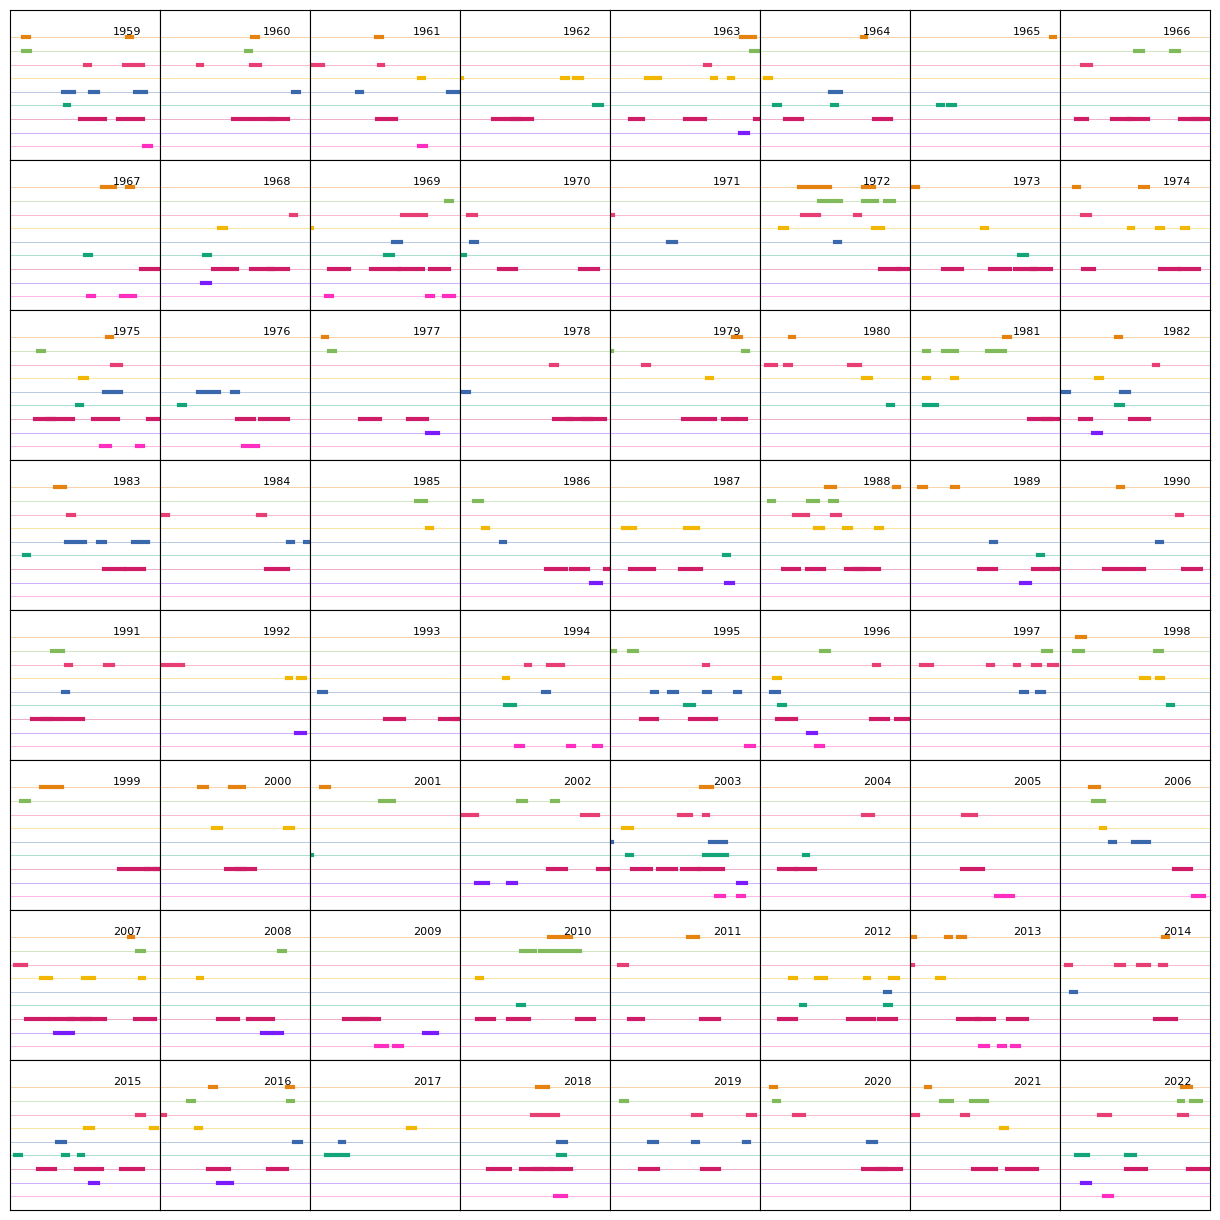

In [24]:
colors = [COLORS[2], COLORS[1], COLORS[3], *colormaps.bold(np.linspace(0, 1, 11))[1:]]
for spell in spells_list.values():
    print(spell["spell"].max())
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.axis("off")
for spell_name, color in zip(spells_list, colors):
    ax.plot([], [], color=color, lw=3, label=spell_name)
ax.legend()
plt.show()
fig, axes = plt.subplots(
    8,
    8,
    figsize=(12, 12),
    gridspec_kw=dict(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1),
    subplot_kw=dict(xticks=[], yticks=[], xlim=[-1, 95], ylim=[-1, 10]),
)
axes = axes.ravel()
for ax, year in zip(axes, YEARS):
    ax.text(65, len(spells_list) - 0.8, f"{year}", fontsize=8)
    for j, (name_, spell) in enumerate(spells_list.items()):
        ax.plot([-1, 95], [j, j], color=colors[j], lw=0.5, ls="solid", alpha=0.5)
        spell_ = spell.filter(pl.col("time").dt.year() == year)
        if len(spell_) == 0:
            continue
        for s, indiv_spell in spell_.group_by("spell"):
            x = [
                indiv_spell["time"].dt.ordinal_day().first() - 152,
                indiv_spell["time"].dt.ordinal_day().last() - 152,
            ]
            y = [j, j]
            ax.plot(x, y, color=colors[j], lw=3)

Text(0.5, 1.0, 'Persistent episode frequency')

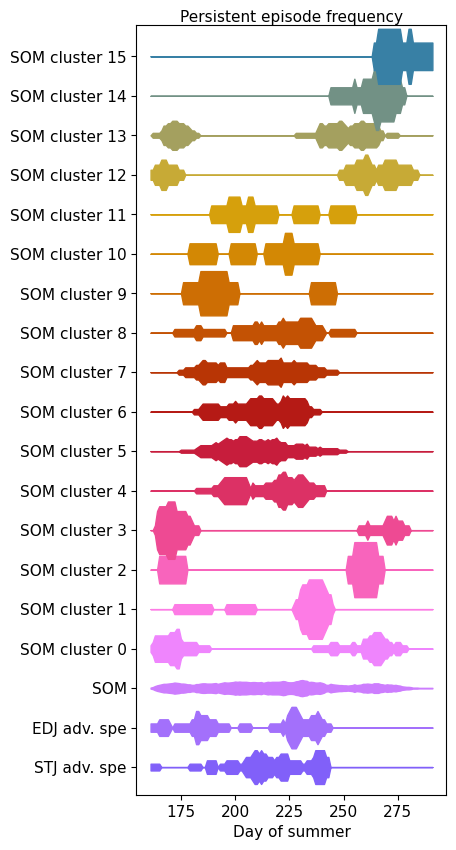

In [25]:
fig, ax = plt.subplots(figsize=(4, 10))
keys = [
    key for key in spells_list_extended if key not in [*DUNCANS_REGIONS_NAMES, "abs"]
]
colors = colormaps.cet_c_mrybm_35(np.linspace(0.1, 0.9, len(keys)))
dy = 0.07
spells_list_reduced = [
    spells_list_extended[key][["spell", "time"]]
    .with_columns(type=pl.lit(key))
    .cast({"time": pl.Datetime("ms")})
    for key in keys
]
counts = (
    pl.concat(spells_list_reduced)
    .group_by(
        pl.col("time").dt.ordinal_day().alias("dayofyear"),
        pl.col("type"),
        maintain_order=True,
    )
    .len()
)
counts = (
    counts[["dayofyear"]]
    .unique("dayofyear")
    .join(counts[["type"]].unique("type"), how="cross")
    .join(counts, how="left", on=["dayofyear", "type"])
    .fill_null(0)
)
counts = counts.with_columns(prop=(pl.col("len") / pl.col("len").sum()).over("type"))
for i, key in enumerate(keys):
    subdf = counts.filter(pl.col("type") == key)
    subdf = subdf.sort("dayofyear")
    ax.fill_between(
        subdf["dayofyear"],
        i * dy + subdf["prop"],
        i * dy - subdf["prop"],
        color=colors[i % len(colors)],
    )
ax.set_ylim([-dy * 0.7, (i + 0.8) * dy])
ax.set_xlabel("Day of summer")
ax.set_yticks(dy * np.arange(len(keys)), labels=keys)
ax.set_title("Persistent episode frequency")

In [26]:
if "SOM" in spells_list_extended:
    del spells_list_extended["SOM"]
if "abs" in spells_list_extended:
    del spells_list_extended["abs"]
overlaps = np.zeros((len(spells_list_extended), len(spells_list_extended)))
for i, val1 in enumerate(spells_list_extended.values()):
    for j, val2 in enumerate(spells_list_extended.values()):
        overlaps[i, j] = (
            val1["time"]
            .cast(pl.Datetime("ms"))
            .is_in(val2["time"].cast(pl.Datetime("ms")))
            .mean()
        )

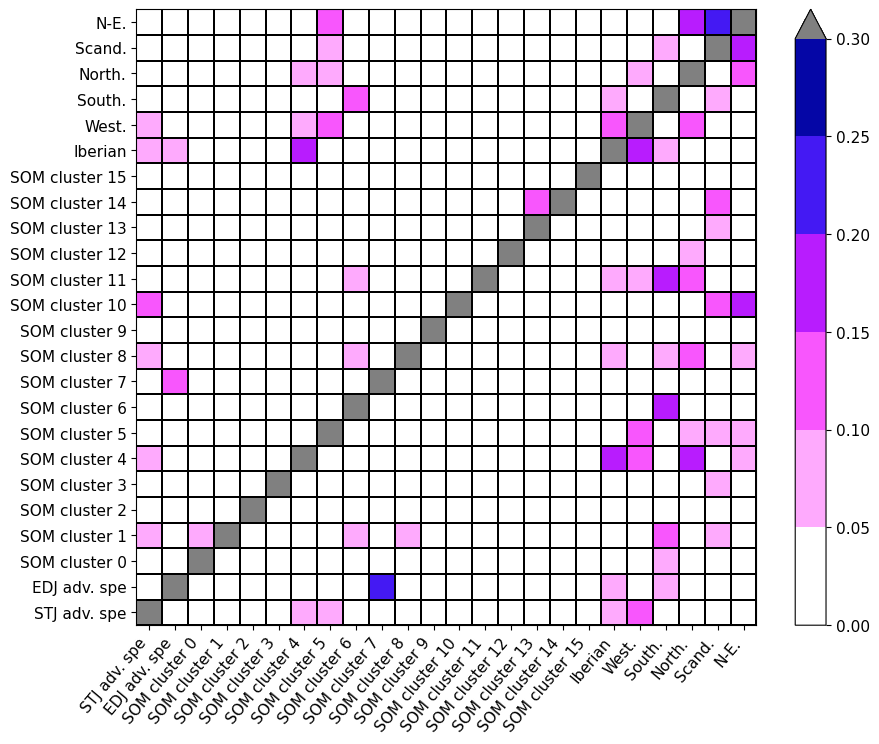

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
levels = np.arange(0, 0.33, 0.05)
cmap = colormaps.cet_l_bmw_r
cmap = make_transparent(cmap, len(levels), 1)
cmap.set_over("grey")
norm = BoundaryNorm(levels, cmap.N, extend="max")
im = ax.pcolormesh(
    overlaps, cmap=cmap, norm=norm, lw=0.1, ls="solid", edgecolor="black"
)
fig.colorbar(im, ax=ax)
ax.set_xticks(
    np.arange(len(spells_list_extended)) + 0.5,
    list(spells_list_extended),
    ha="right",
    rotation=50,
)
ax.set_yticks(np.arange(len(spells_list_extended)) + 0.5, list(spells_list_extended))
a = 1

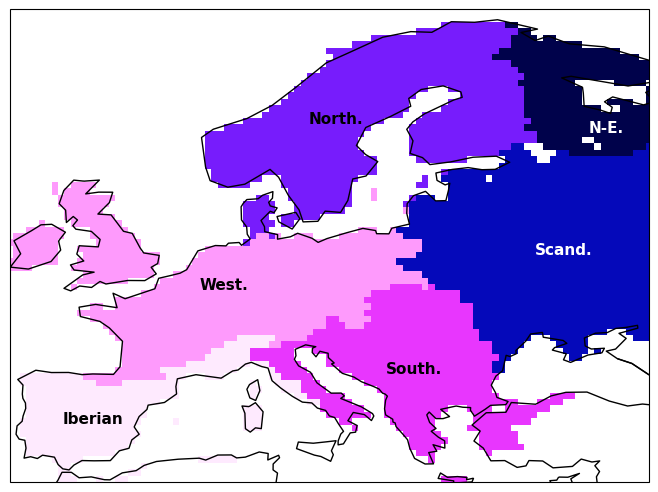

In [28]:
clusters_da = np.abs(
    xr.open_dataarray(Path(DATADIR, "ERA5/heatwaves_duncan/cluster_df.nc")).load()
)
clu = Clusterplot(1, 1, (-10, 40, 35, 72))
cmap = colormaps.cet_l_bmw_r
ax = clu.axes[0]
unique_clusters = np.arange(1, 7)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, add_labels=False)
for j in range(6):
    lo = (
        clusters_da.lon.where(clusters_da == (j + 1)).mean().item()
        - j
        - 2 * (j == 0)
        + 2 * (j == 2)
        + 1.5 * (j == 1)
        - (j == 4)
    )
    la = clusters_da.lat.where(clusters_da == (j + 1)).mean().item() - (j == 5) * 2
    color = "white" if j >= 4 else "black"
    ax.text(
        lo,
        la,
        DUNCANS_REGIONS_NAMES[j],
        ha="center",
        va="center",
        fontweight="bold",
        color=color,
    )

plt.savefig(f"{FIGURES}/Poster_EGU25/centers.png")

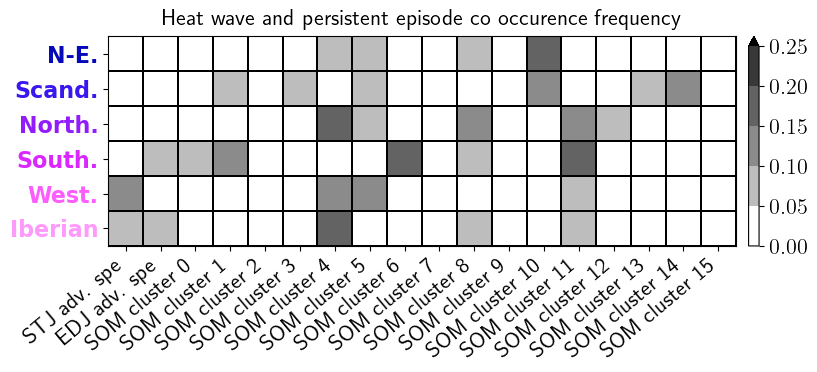

In [29]:
plt.style.use("default")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

fig, ax = plt.subplots(figsize=(10, 4), tight_layout=False)
levels = np.arange(0, 0.26, 0.05)
cmap = colormaps.grayc_r
cmap = make_transparent(cmap, len(levels), 1)
norm = BoundaryNorm(levels, cmap.N, extend="max")
im = ax.pcolormesh(
    overlaps[:-6, -6:].T, cmap=cmap, norm=norm, lw=0.1, ls="solid", edgecolor="black"
)
ylabel_colors = colormaps.cet_l_bmw_r(np.linspace(0.2, 0.8, 6))
fig.colorbar(im, ax=ax, fraction=0.25, shrink=1, pad=0.015)
ax.set_title("Heat wave and persistent episode co occurence frequency", pad=8)
ax.set_yticks(
    np.arange(6) + 0.5, list(spells_list_extended)[-6:], ha="right", rotation=0
)
for color, ticklabel, tick in zip(
    ylabel_colors, ax.yaxis.get_ticklabels(), ax.yaxis.get_ticklines()
):
    ticklabel.set_color(color)
    ticklabel.set_weight("demi")
    ticklabel.set_usetex(False)
    tick.set_color(color)
ax.set_xticks(
    np.arange(len(spells_list_extended) - 6) + 0.5,
    list(spells_list_extended)[:-6],
    rotation=40,
    ha="right",
)
plt.savefig(f"{FIGURES}/Poster_EGU25/heat_waves_co_occurence.png")

# Compare with CDSK

In [30]:
import CDSK

da_ = coarsen_da(ds["s"], 7, np.amax)
da_anom = compute_anomalies_ds(da_, "dayofyear", standardized=True)

In [31]:
X = da_.values.reshape(da_.shape[0], -1)
theta1 = CDSK.compute_theta(X[:30000], n_jobs=N_WORKERS)[:, 0, 0]
theta2 = CDSK.compute_theta(X[30000:60000], n_jobs=N_WORKERS)[:, 0, 0]
theta3 = CDSK.compute_theta(X[60000:], n_jobs=N_WORKERS)[:, 0, 0]
theta = np.concatenate([theta1, theta2, theta3])

In [32]:
theta_pd = pl.DataFrame({"time": da_.time.values, "theta": theta})

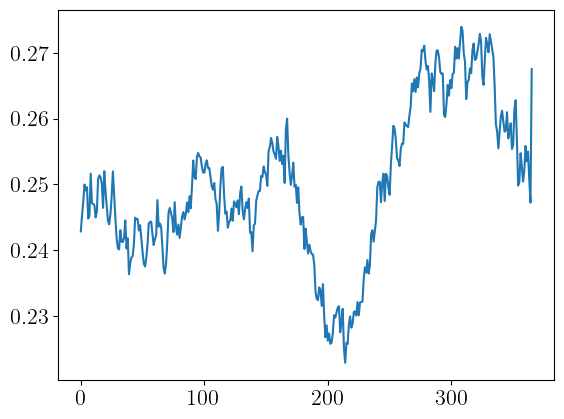

In [33]:
plt.plot(theta_pd.group_by(pl.col("time").dt.ordinal_day(), maintain_order=True).mean()["theta"])

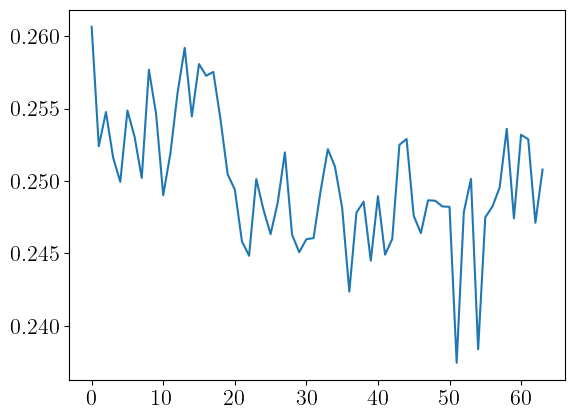

In [34]:
plt.plot(theta_pd.group_by(pl.col("time").dt.year(), maintain_order=True).mean()["theta"])

In [35]:
speed_realspace = ((da_anom.data[1:] - da_anom.data[:-1])  ** 2).sum(axis=(1, 2))
speed_realspace = compute(speed_realspace, progress_flag=True)
speed_realspace = pl.DataFrame({"time": da_.time.values[1:], "speed": speed_realspace})

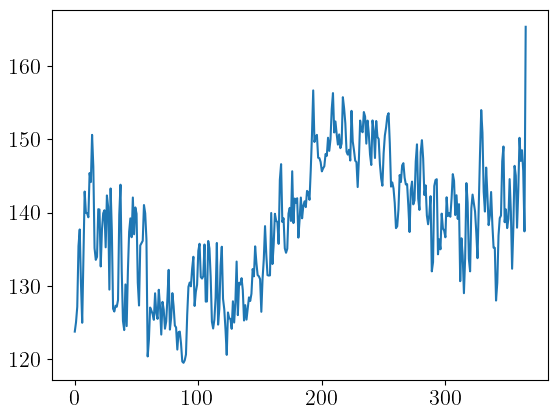

In [36]:
plt.plot(speed_realspace.group_by(pl.col("time").dt.ordinal_day(), maintain_order=True).mean()["speed"])

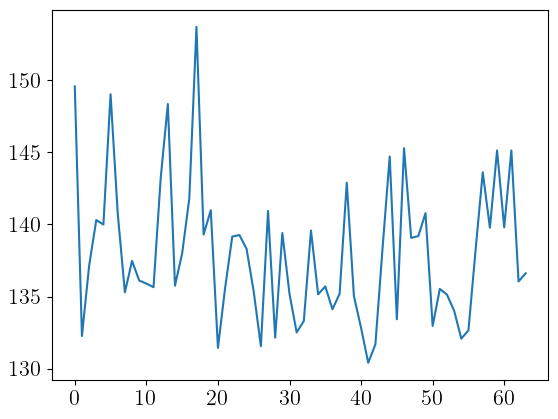

In [37]:
plt.plot(speed_realspace.group_by(pl.col("time").dt.year(), maintain_order=True).mean()["speed"])

In [38]:
np.corrcoef(speed_realspace["speed"].to_numpy(), theta[1:])

array([[1.     , 0.29641],
       [0.29641, 1.     ]])

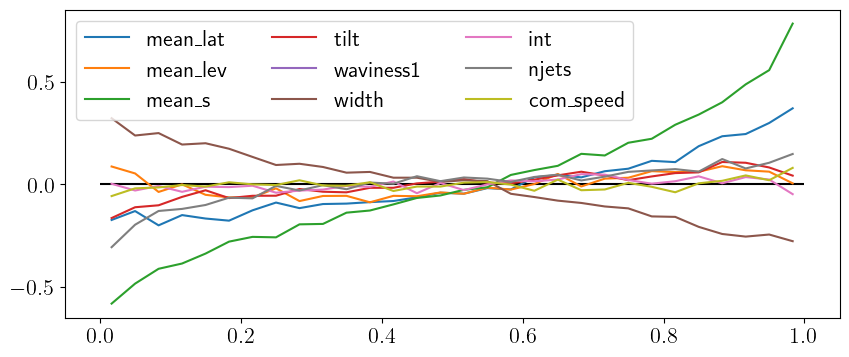

In [39]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
    "com_speed",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
spe = speed_realspace["speed"].to_numpy()
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = (spe < np.quantile(spe, q2)) & (spe >= np.quantile(spe, q1))
    props = props_as_df_anoms.filter(pl.col("jet") == "EDJ")[np.where(filter_)[0]].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

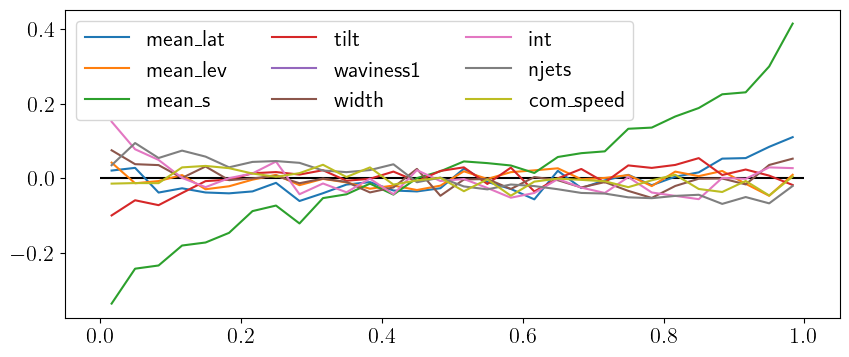

In [40]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
    "com_speed",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
spe = speed_realspace["speed"].to_numpy()
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = (spe < np.quantile(spe, q2)) & (spe >= np.quantile(spe, q1))
    props = props_as_df_anoms.filter(pl.col("jet") == "STJ")[np.where(filter_)[0]].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

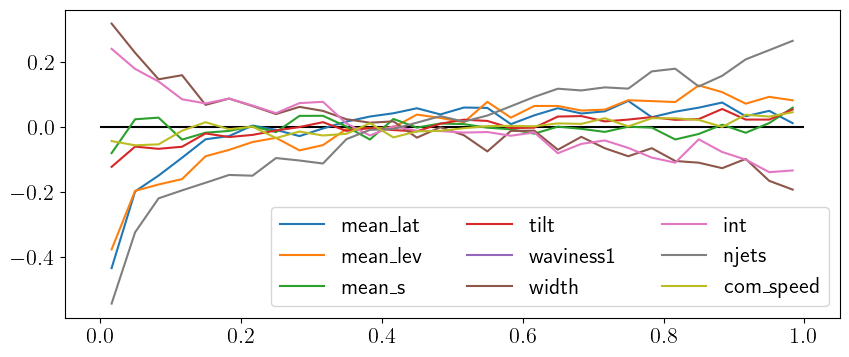

In [41]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
    "com_speed",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = (theta < np.quantile(theta, q2)) & (theta >= np.quantile(theta, q1))
    props = props_as_df_anoms.filter(pl.col("jet") == "EDJ")[np.where(filter_)[0]].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

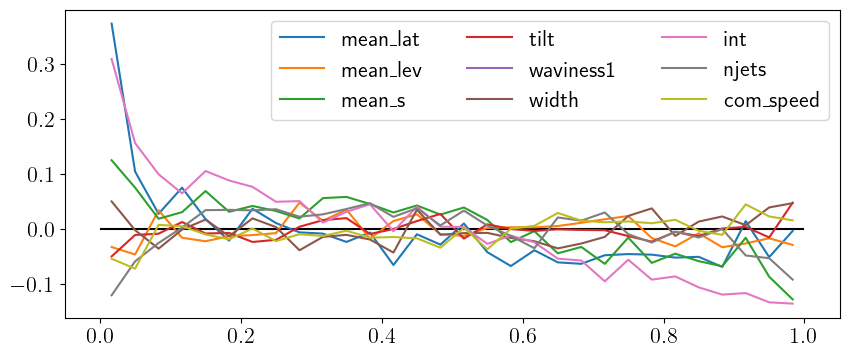

In [42]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
    "com_speed",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = (theta < np.quantile(theta, q2)) & (theta >= np.quantile(theta, q1))
    props = props_as_df_anoms.filter(pl.col("jet") == "STJ")[np.where(filter_)[0]].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

# Natural coordinates composites

In [43]:
def symmetrize_p(
    pvals: xr.DataArray | np.ndarray, direction: int, q: float
) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q


def plot_all_relative_composites(jets, times, variable_dict, n_bootstraps: int = 50):
    figs = []
    for varname, props in variable_dict.items():
        if len(props) == 3:
            da, nlevels, cmap = props
            clim = None
        else:
            da, clim, nlevels, cmap = props
        hatch = "xxx" if varname == "tp" else "xx"

        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets, times, da, n_bootstraps=n_bootstraps, clim=clim
        )
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds

        direction = infer_direction(to_plot)
        symmetric = direction == 0

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
            to_plot.quantile(0.01), to_plot.quantile(0.99)
        )
        norm = BoundaryNorm(levels, cmap.N)

        axes[0].pcolormesh(
            to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap
        )
        filter_ = symmetrize_p(pvals[0].T, direction, 0.05)
        axes[0].pcolor(
            pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
        )

        axes[1].pcolormesh(
            to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap
        )
        filter_ = symmetrize_p(pvals[1].T, direction, 0.05)
        axes[1].pcolor(
            pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
        )

        fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
        figs.append(fig)
    return figs


# clim_T = xr.open_dataarray(exp.path.joinpath("t2m_relative_clim.nc"))
# clim_tp = xr.open_dataarray(exp.path.joinpath("tp_relative_clim.nc"))
# clim_apvs = xr.open_dataarray(exp.path.joinpath("apvs_relative_clim.nc"))
# clim_cpvs = xr.open_dataarray(exp.path.joinpath("cpvs_relative_clim.nc"))
# clim_sst = xr.open_dataarray(exp.path.joinpath("sst_relative_clim.nc"))

# variable_dict = {
#     "t2m": [da_T, clim_T, 8, colormaps.BlWhRe],
#     "tp": [da_tp, clim_tp, 15, colormaps.precip4_diff_19lev],
#     "APVS": [da_apvs, clim_apvs, 7, colormaps.curl],
#     "CPVS": [da_cpvs, clim_cpvs, 7, colormaps.curl],
#     "sst": [da_sst, clim_sst, 7, colormaps.BlWhRe]
# }
variable_dict = {
    "t2m": [da_T, 8, colormaps.BlWhRe],
    "tp": [da_tp * 1000, 15, colormaps.precip4_diff_19lev],
    "apvs": [da_apvs * 100, 7, colormaps.curl],
    "cpvs": [da_cpvs * 100, 7, colormaps.curl],
}
long_names = {
    "t2m": "2m temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
}

NameError: name 'da_T' is not defined

## Mean anomaly at onset

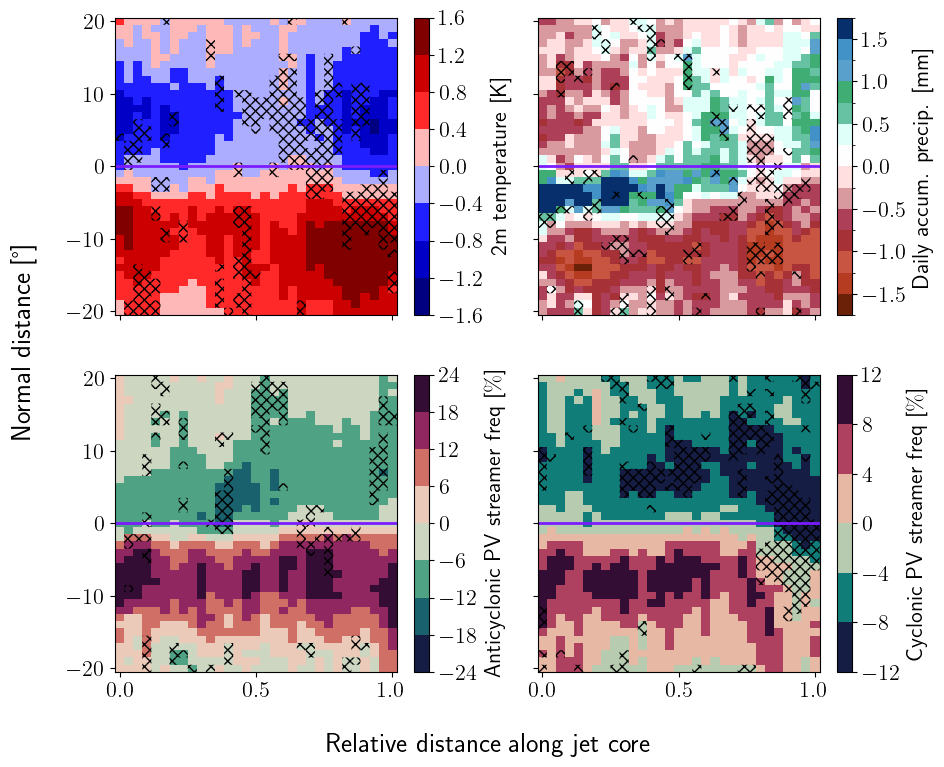

In [ ]:
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("font", size=16)
plt.rc("savefig", dpi=300)


spells_from_jet = spells_list_time_before["STJ adv. spe"]
spells_from_jet = subset_around_onset(
    spells_from_jet, around_onset=datetime.timedelta(days=1)
)
jets = all_jets_one_df.filter(
    pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8])
)
spells_from_jet = spells_from_jet.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
fig, axes = plt.subplots(
    2, 2, figsize=(10, 8.5), sharex="all", sharey="all", gridspec_kw=dict(wspace=0.2)
)
axes = axes.ravel()
times = spells_from_jet
n_bootstraps = 30
for i, (varname, props) in enumerate(variable_dict.items()):
    ax = axes[i]
    if len(props) == 3:
        da, nlevels, cmap = props
        clim = None
    else:
        da, clim, nlevels, cmap = props
    hatch = "xxx"

    jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
        jets, times, da, n_bootstraps=n_bootstraps, clim=clim
    )
    try:
        to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
        pvals = jets_during_spells_with_interp_norm_ds["pvals"]
    except KeyError:
        to_plot = jets_during_spells_with_interp_norm_ds

    direction = infer_direction(to_plot)
    symmetric = direction == 0

    levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
        to_plot.quantile(0.01), to_plot.quantile(0.99)
    )
    norm = BoundaryNorm(levels, cmap.N)

    ax.pcolormesh(to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap)
    filter_ = symmetrize_p(pvals[1].T, direction, 0.1)
    ax.pcolor(
        pvals.norm_index, pvals.n, pvals[1].T.where(filter_), hatch=hatch, alpha=0.0
    )
    xlim = ax.get_xlim()
    ax.plot((-0.1, 1.1), (0, 0), lw=2, color=COLORS[1])
    ax.set_xlim(xlim)
    cbar = fig.colorbar(ScalarMappable(norm, cmap), ax=ax, spacing="proportional")
    cbar.set_label(long_names[varname], fontsize=16)

fig.supylabel("Normal distance [°]")
fig.supxlabel("Relative distance along jet core")
plt.draw()

plt.savefig(f"{FIGURES}/Poster_EGU25/STJ_spells_EDJ_composites.png")

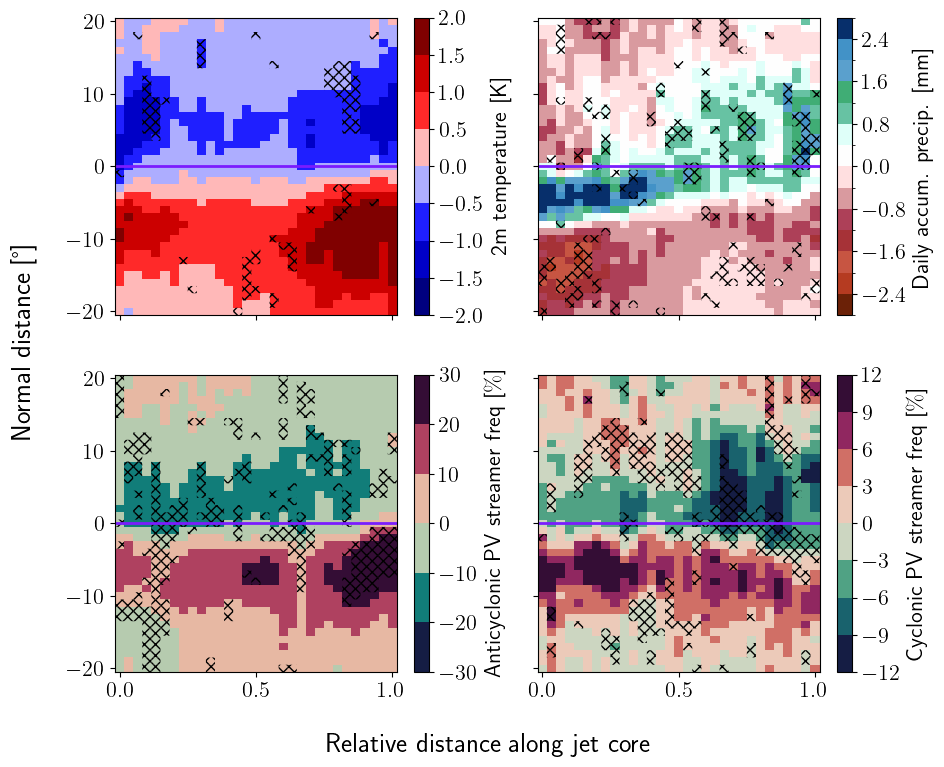

In [ ]:
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("font", size=16)
plt.rc("savefig", dpi=300)


spells_from_jet = spells_list_time_before["EDJ adv. spe"]
spells_from_jet = subset_around_onset(
    spells_from_jet, around_onset=datetime.timedelta(days=1)
)
jets = all_jets_one_df.filter(
    pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8])
)
spells_from_jet = spells_from_jet.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
fig, axes = plt.subplots(
    2, 2, figsize=(10, 8.5), sharex="all", sharey="all", gridspec_kw=dict(wspace=0.2)
)
axes = axes.ravel()
times = spells_from_jet
n_bootstraps = 30
for i, (varname, props) in enumerate(variable_dict.items()):
    ax = axes[i]
    if len(props) == 3:
        da, nlevels, cmap = props
        clim = None
    else:
        da, clim, nlevels, cmap = props
    hatch = "xxx"

    jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
        jets, times, da, n_bootstraps=n_bootstraps, clim=clim
    )
    try:
        to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
        pvals = jets_during_spells_with_interp_norm_ds["pvals"]
    except KeyError:
        to_plot = jets_during_spells_with_interp_norm_ds

    direction = infer_direction(to_plot)
    symmetric = direction == 0

    levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
        to_plot.quantile(0.01), to_plot.quantile(0.99)
    )
    norm = BoundaryNorm(levels, cmap.N)

    ax.pcolormesh(to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap)
    filter_ = symmetrize_p(pvals[1].T, direction, 0.1)
    ax.pcolor(
        pvals.norm_index, pvals.n, pvals[1].T.where(filter_), hatch=hatch, alpha=0.0
    )
    xlim = ax.get_xlim()
    ax.plot((-0.1, 1.1), (0, 0), lw=2, color=COLORS[1])
    ax.set_xlim(xlim)
    cbar = fig.colorbar(ScalarMappable(norm, cmap), ax=ax, spacing="proportional")
    cbar.set_label(long_names[varname], fontsize=16)

fig.supylabel("Normal distance [°]")
fig.supxlabel("Relative distance along jet core")
plt.draw()

plt.savefig(f"{FIGURES}/Poster_EGU25/EDJ_spells_EDJ_composites.png")

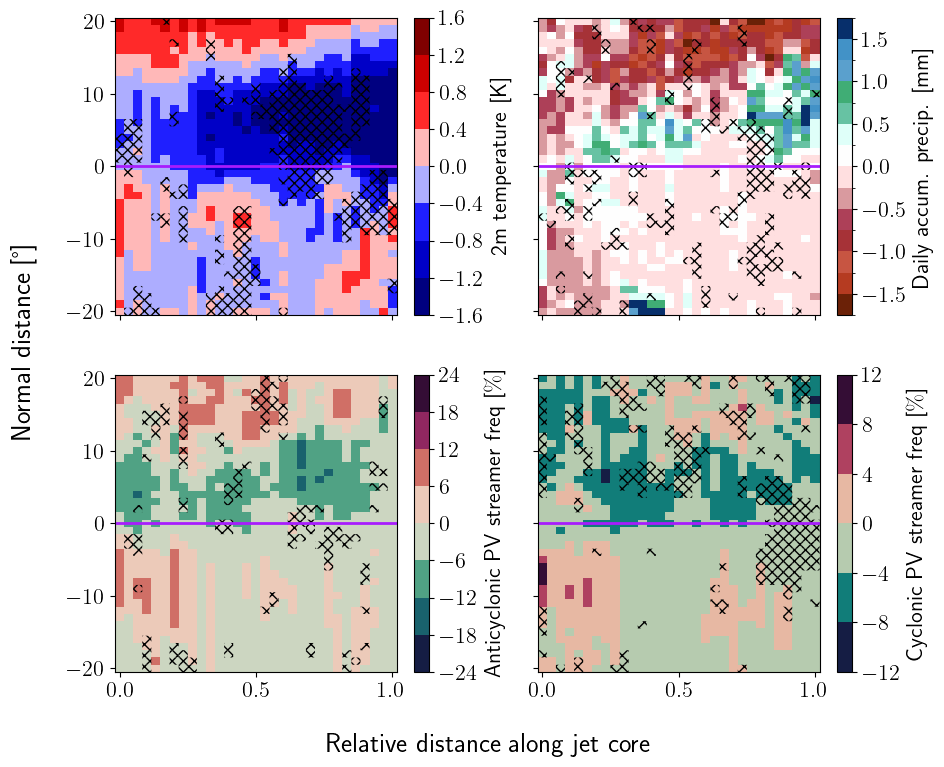

In [ ]:
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("font", size=16)
plt.rc("savefig", dpi=300)


spells_from_jet = spells_list_time_before["STJ adv. spe"]
spells_from_jet = subset_around_onset(
    spells_from_jet, around_onset=datetime.timedelta(days=1)
)
jets = all_jets_one_df.filter(
    pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8])
)
spells_from_jet = spells_from_jet.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
fig, axes = plt.subplots(
    2, 2, figsize=(10, 8.5), sharex="all", sharey="all", gridspec_kw=dict(wspace=0.2)
)
axes = axes.ravel()
times = spells_from_jet
n_bootstraps = 30
for i, (varname, props) in enumerate(variable_dict.items()):
    ax = axes[i]
    if len(props) == 3:
        da, nlevels, cmap = props
        clim = None
    else:
        da, clim, nlevels, cmap = props
    hatch = "xxx"

    jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
        jets, times, da, n_bootstraps=n_bootstraps, clim=clim
    )
    try:
        to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
        pvals = jets_during_spells_with_interp_norm_ds["pvals"]
    except KeyError:
        to_plot = jets_during_spells_with_interp_norm_ds

    direction = infer_direction(to_plot)
    symmetric = direction == 0

    levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
        to_plot.quantile(0.01), to_plot.quantile(0.99)
    )
    norm = BoundaryNorm(levels, cmap.N)

    ax.pcolormesh(to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap)
    filter_ = symmetrize_p(pvals[1].T, direction, 0.1)
    ax.pcolor(
        pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
    )
    xlim = ax.get_xlim()
    ax.plot((-0.1, 1.1), (0, 0), lw=2, color=COLORS[0])
    ax.set_xlim(xlim)
    cbar = fig.colorbar(ScalarMappable(norm, cmap), ax=ax, spacing="proportional")
    cbar.set_label(long_names[varname], fontsize=16)

fig.supylabel("Normal distance [°]")
fig.supxlabel("Relative distance along jet core")
plt.draw()

plt.savefig(f"{FIGURES}/Poster_EGU25/STJ_spells_STJ_composites.png")

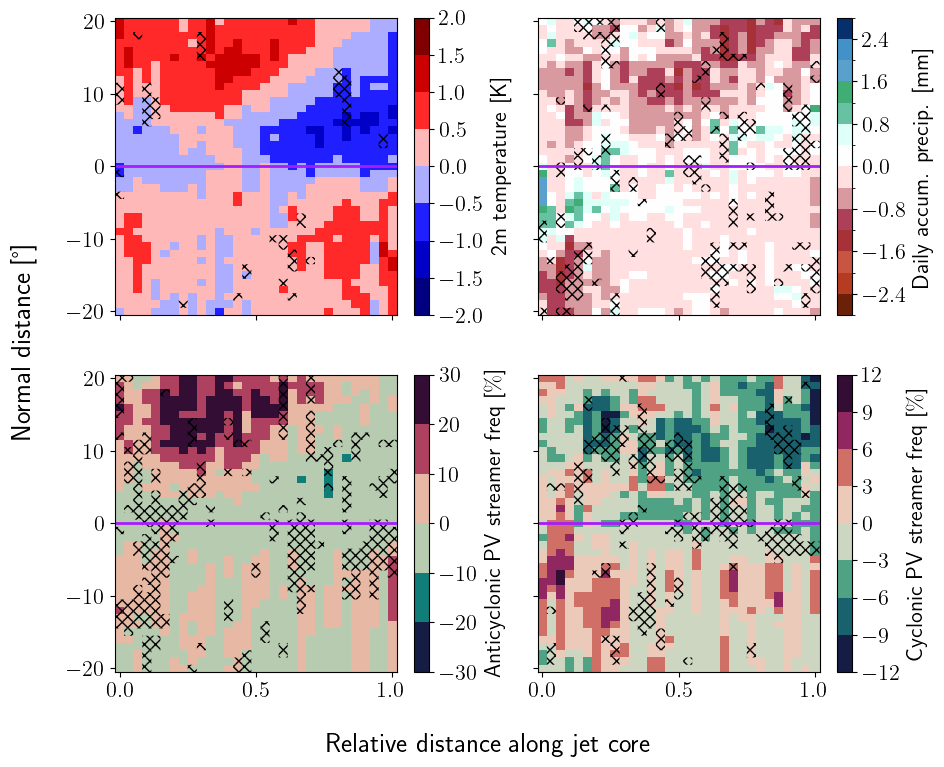

In [ ]:
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("font", size=16)
plt.rc("savefig", dpi=300)


spells_from_jet = spells_list_time_before["EDJ adv. spe"]
spells_from_jet = subset_around_onset(
    spells_from_jet, around_onset=datetime.timedelta(days=1)
)
jets = all_jets_one_df.filter(
    pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8])
)
spells_from_jet = spells_from_jet.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
fig, axes = plt.subplots(
    2, 2, figsize=(10, 8.5), sharex="all", sharey="all", gridspec_kw=dict(wspace=0.2)
)
axes = axes.ravel()
times = spells_from_jet
n_bootstraps = 30
for i, (varname, props) in enumerate(variable_dict.items()):
    ax = axes[i]
    if len(props) == 3:
        da, nlevels, cmap = props
        clim = None
    else:
        da, clim, nlevels, cmap = props
    hatch = "xxx"

    jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
        jets, times, da, n_bootstraps=n_bootstraps, clim=clim
    )
    try:
        to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
        pvals = jets_during_spells_with_interp_norm_ds["pvals"]
    except KeyError:
        to_plot = jets_during_spells_with_interp_norm_ds

    direction = infer_direction(to_plot)
    symmetric = direction == 0

    levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
        to_plot.quantile(0.01), to_plot.quantile(0.99)
    )
    norm = BoundaryNorm(levels, cmap.N)

    ax.pcolormesh(to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap)
    filter_ = symmetrize_p(pvals[1].T, direction, 0.1)
    ax.pcolor(
        pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
    )
    xlim = ax.get_xlim()
    ax.plot((-0.1, 1.1), (0, 0), lw=2, color=COLORS[0])
    ax.set_xlim(xlim)
    cbar = fig.colorbar(ScalarMappable(norm, cmap), ax=ax, spacing="proportional")
    cbar.set_label(long_names[varname], fontsize=16)

fig.supylabel("Normal distance [°]")
fig.supxlabel("Relative distance along jet core")
plt.draw()

plt.savefig(f"{FIGURES}/Poster_EGU25/EDJ_spells_STJ_composites.png")

## jet coordinate time series: hovmoller time x normal, one for each half of the jet...

In [ ]:
jets = all_jets_one_df.filter(
    pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8])
)

In [ ]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
spells_from_jet = spells_from_jet.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
jets_with_interp = _gather_normal_da_jets_wrapper(jets, spells_from_jet, da_tp)
tentative = jets_with_interp.group_by(
    pl.col("is_polar") > 0.5,
    "relative_index",
    "relative_time",
    pl.col("norm_index") > 0.5,
    "n",
    maintain_order=True,
).agg(pl.col("tp_interp").mean())
(
    1000
    * polars_to_xarray(
        tentative, index_columns=["is_polar", "norm_index", "relative_index", "n"]
    )["tp_interp"][:, :, :18]
).plot(
    row="is_polar",
    col="norm_index",
    x="relative_index",
    y="n",
    levels=8,
    cmap=colormaps.precip4_diff_19lev,
    extend="neither",
)

In [ ]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
spells_from_jet = spells_from_jet.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
jets_with_interp = _gather_normal_da_jets_wrapper(jets, spells_from_jet, da_T)
tentative = jets_with_interp.group_by(
    pl.col("is_polar") > 0.5,
    "relative_index",
    "relative_time",
    pl.col("norm_index") > 0.5,
    "n",
    maintain_order=True,
).agg(pl.col("t2m_interp").mean())
polars_to_xarray(
    tentative, index_columns=["is_polar", "norm_index", "relative_index", "n"]
)["t2m_interp"][:, :, :18].plot(
    row="is_polar",
    col="norm_index",
    x="relative_index",
    y="n",
    levels=8,
    cmap=colormaps.BlWhRe,
)

In [ ]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
spells_from_jet = spells_from_jet.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
jets_with_interp = _gather_normal_da_jets_wrapper(jets, spells_from_jet, da_apvs)
tentative = jets_with_interp.group_by(
    pl.col("is_polar") > 0.5,
    "relative_index",
    "relative_time",
    pl.col("norm_index") > 0.5,
    "n",
    maintain_order=True,
).agg(pl.col("apvs_interp").mean())
polars_to_xarray(
    tentative, index_columns=["is_polar", "norm_index", "relative_index", "n"]
)["apvs_interp"][:, :, :18].plot(
    row="is_polar",
    col="norm_index",
    x="relative_index",
    y="n",
    levels=8,
    cmap=colormaps.curl,
)

In [ ]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
spells_from_jet = spells_from_jet.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
jets_with_interp = _gather_normal_da_jets_wrapper(jets, spells_from_jet, da_cpvs)
tentative = jets_with_interp.group_by(
    pl.col("is_polar") > 0.5,
    "relative_index",
    "relative_time",
    pl.col("norm_index") > 0.5,
    "n",
    maintain_order=True,
).agg(pl.col("cpvs_interp").mean())
polars_to_xarray(
    tentative, index_columns=["is_polar", "norm_index", "relative_index", "n"]
)["cpvs_interp"][:, :, :18].plot(
    row="is_polar",
    col="norm_index",
    x="relative_index",
    y="n",
    levels=8,
    cmap=colormaps.curl,
)

# Relative time series

28


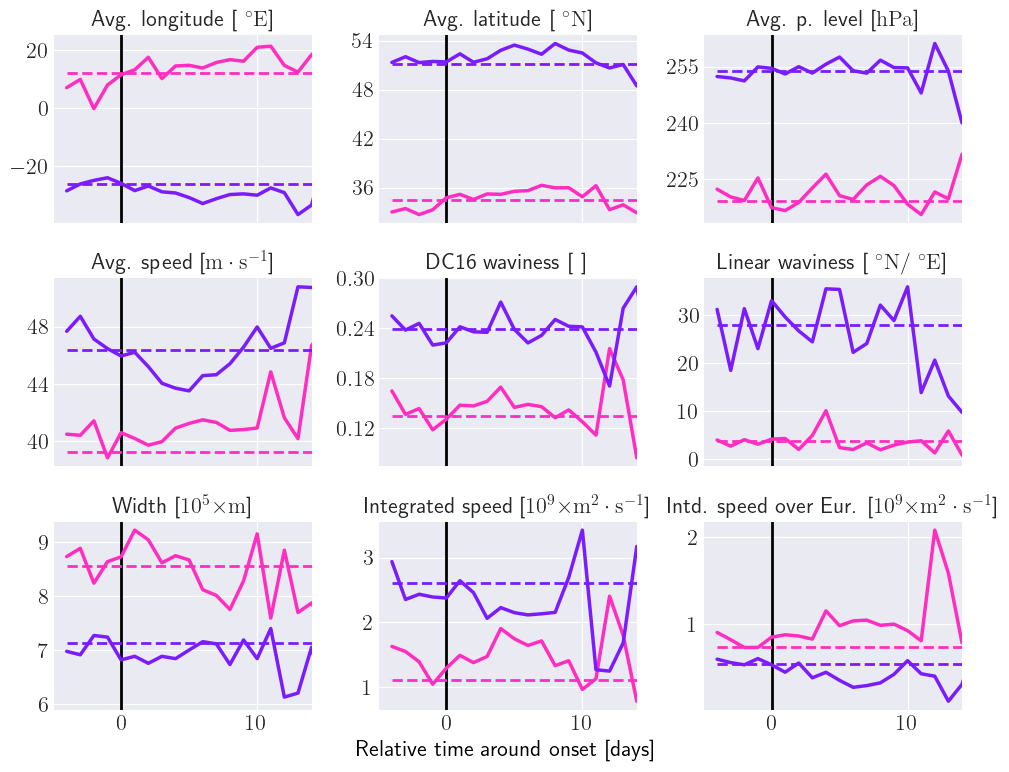

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

spells_from_jet = spells_list_time_before["STJ adv. spe"]
props_masked = mask_from_spells_pl(
    spells_from_jet, props_as_df, time_before=datetime.timedelta(days=4)
)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "wavinessDC16",
    "waviness1",
    "width",
    "int",
    "int_over_europe",
]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
    **aggs
)
fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex="all", tight_layout=False)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        factor = 1e5 if data_var == "width" else factor
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
        if j == 0:
            factor_str = "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
            ax.set_title(
                rf"{PRETTIER_VARNAME[data_var]} [{factor_str}{UNITS[data_var]}]"
            )
        ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
for i, ax in enumerate(axes):
    ax.axvline(0, zorder=1, color="black", lw=2)
    ax.set_xlim([ax.get_xlim()[0], 14])
    if i == len(axes) - 2:
        ax.set_xlabel("Relative time around onset [days]", color="black")
print(props_masked["spell"].max())
fig.set_tight_layout(True)
# fig.savefig(f"{FIGURES}/Poster_EGU25/props_stj_persistence.png")

29


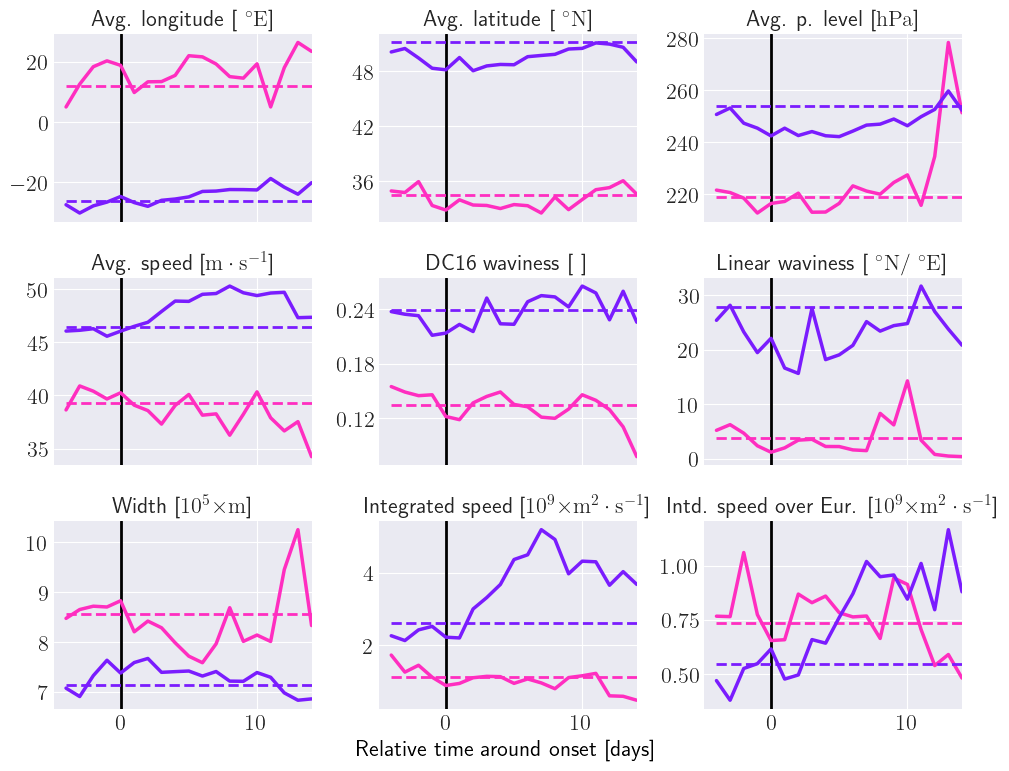

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

spells_from_jet = spells_list_time_before["EDJ adv. spe"]
props_masked = mask_from_spells_pl(
    spells_from_jet, props_as_df, time_before=datetime.timedelta(days=4)
)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "wavinessDC16",
    "waviness1",
    "width",
    "int",
    "int_over_europe",
]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
    **aggs
)
fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex="all", tight_layout=False)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        factor = 1e5 if data_var == "width" else factor
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
        if j == 0:
            factor_str = "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
            ax.set_title(
                rf"{PRETTIER_VARNAME[data_var]} [{factor_str}{UNITS[data_var]}]"
            )
        ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
for i, ax in enumerate(axes):
    ax.axvline(0, zorder=1, color="black", lw=2)
    ax.set_xlim([ax.get_xlim()[0], 14])
    if i == len(axes) - 2:
        ax.set_xlabel("Relative time around onset [days]", color="black")
print(props_masked["spell"].max())
fig.set_tight_layout(True)
# fig.savefig(f"{FIGURES}/Poster_EGU25/props_stj_persistence.png")

# Props vs com speed quantiles

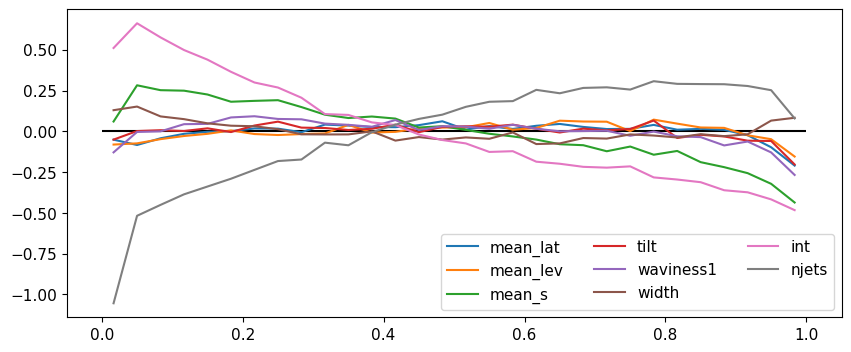

In [86]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
com_speed = props_as_df.filter(pl.col("jet") == "EDJ")["com_speed"]
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = ((com_speed < com_speed.quantile(q2)) & (com_speed >= com_speed.quantile(q1))).arg_true()
    props = props_as_df_anoms.filter(pl.col("jet") == "EDJ")[filter_].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

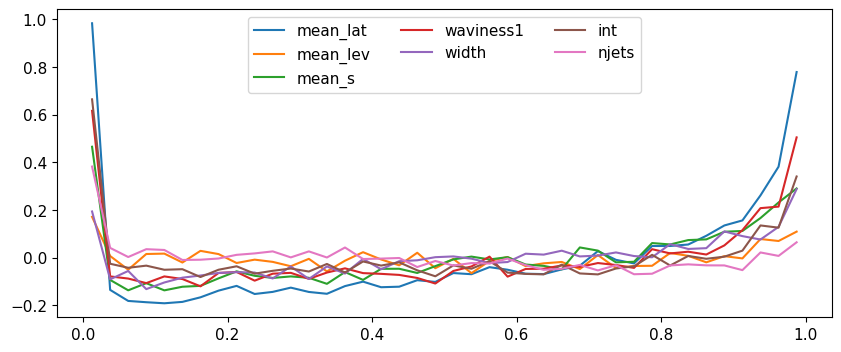

In [51]:
from itertools import pairwise
n_q = 41
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "waviness1",
    "width",
    "int",
    "njets",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
com_speed = props_as_df.filter(pl.col("jet") == "EDJ")["com_speed"]
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = ((com_speed < com_speed.quantile(q2)) & (com_speed >= com_speed.quantile(q1))).arg_true()
    props = props_as_df_anoms.filter(pl.col("jet") == "STJ")[filter_].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

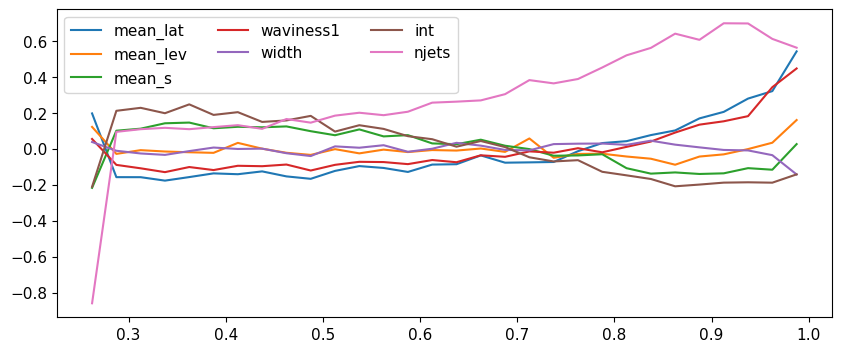

In [52]:
from itertools import pairwise
n_q = 41
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "waviness1",
    "width",
    "int",
    "njets",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
com_speed = props_as_df.filter(pl.col("jet") == "STJ")["com_speed"]
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = ((com_speed < com_speed.quantile(q2)) & (com_speed >= com_speed.quantile(q1))).arg_true()
    props = props_as_df_anoms.filter(pl.col("jet") == "STJ")[filter_].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

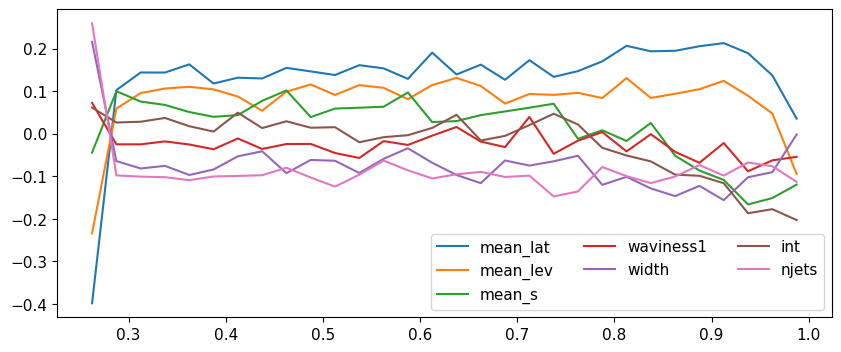

In [53]:
from itertools import pairwise
n_q = 41
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "waviness1",
    "width",
    "int",
    "njets",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
com_speed = props_as_df.filter(pl.col("jet") == "STJ")["com_speed"]
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = ((com_speed < com_speed.quantile(q2)) & (com_speed >= com_speed.quantile(q1))).arg_true()
    props = props_as_df_anoms.filter(pl.col("jet") == "EDJ")[filter_].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

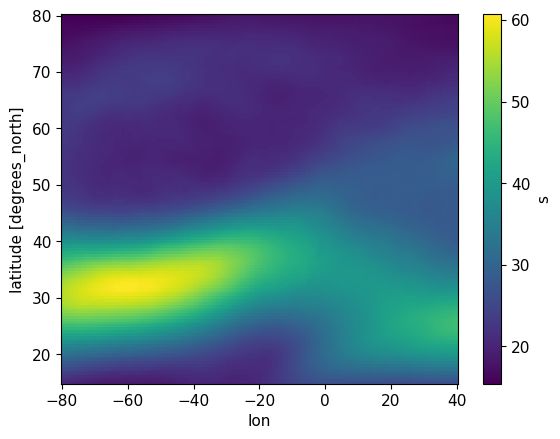

In [51]:
ds["s"][theta < np.quantile(theta, 0.01)].mean("time").plot()

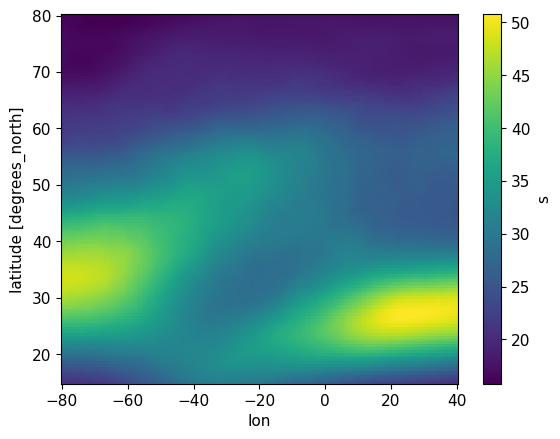

In [33]:
ds["s"][1:][spe < np.quantile(spe, 0.01)].mean("time").plot()

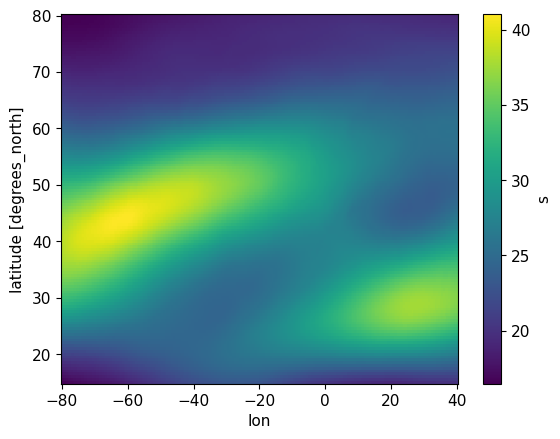

In [41]:
com_speed = props_as_df.filter(pl.col("jet") == "EDJ")["com_speed"]
ds["s"][com_speed < np.nanquantile(com_speed, 0.1)].mean("time").plot()

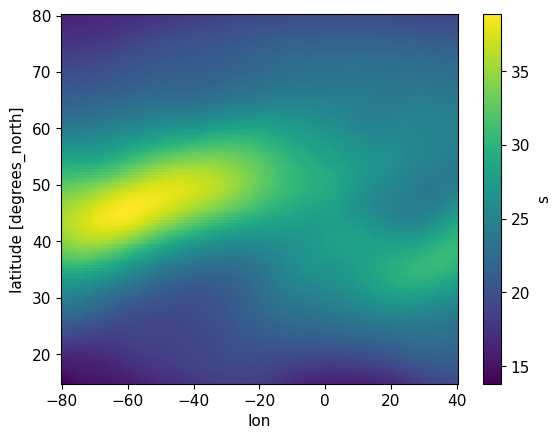

In [43]:
com_speed = props_as_df.filter(pl.col("jet") == "STJ")["com_speed"]
ds["s"][com_speed < np.nanquantile(com_speed, 0.3)].mean("time").plot()

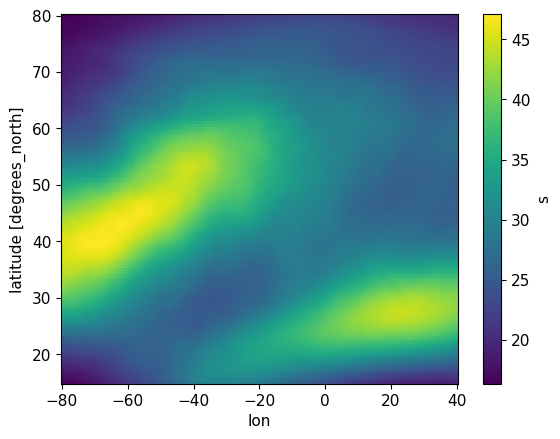

In [34]:
ds["s"][theta > np.quantile(theta, 0.99)].mean("time").plot()

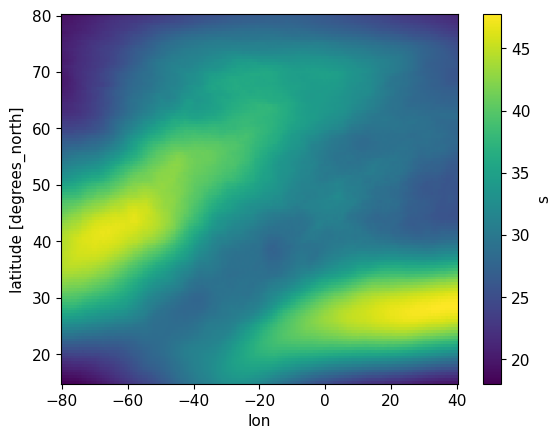

In [35]:
ds["s"][1:][spe > np.quantile(spe, 0.99)].mean("time").plot()

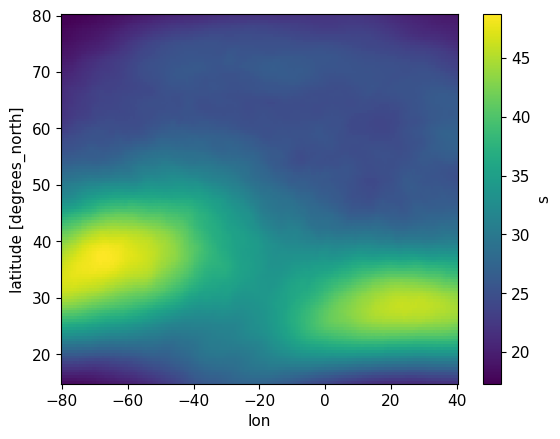

In [44]:
com_speed = props_as_df.filter(pl.col("jet") == "EDJ")["com_speed"]
ds["s"][com_speed > np.nanquantile(com_speed, 0.99)].mean("time").plot()

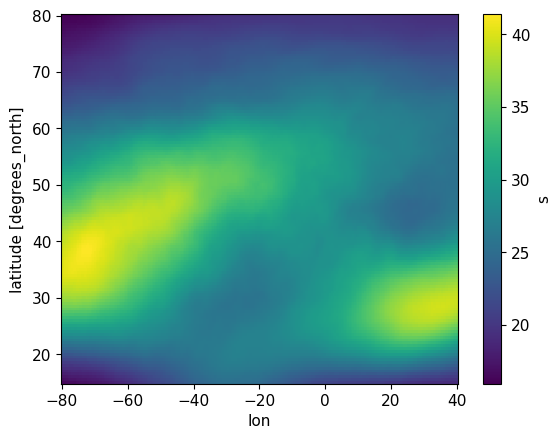

In [45]:
com_speed = props_as_df.filter(pl.col("jet") == "STJ")["com_speed"]
ds["s"][com_speed > np.nanquantile(com_speed, 0.99)].mean("time").plot()

# Relative time real space composites

In [6]:
plt.style.use("default")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

26
19


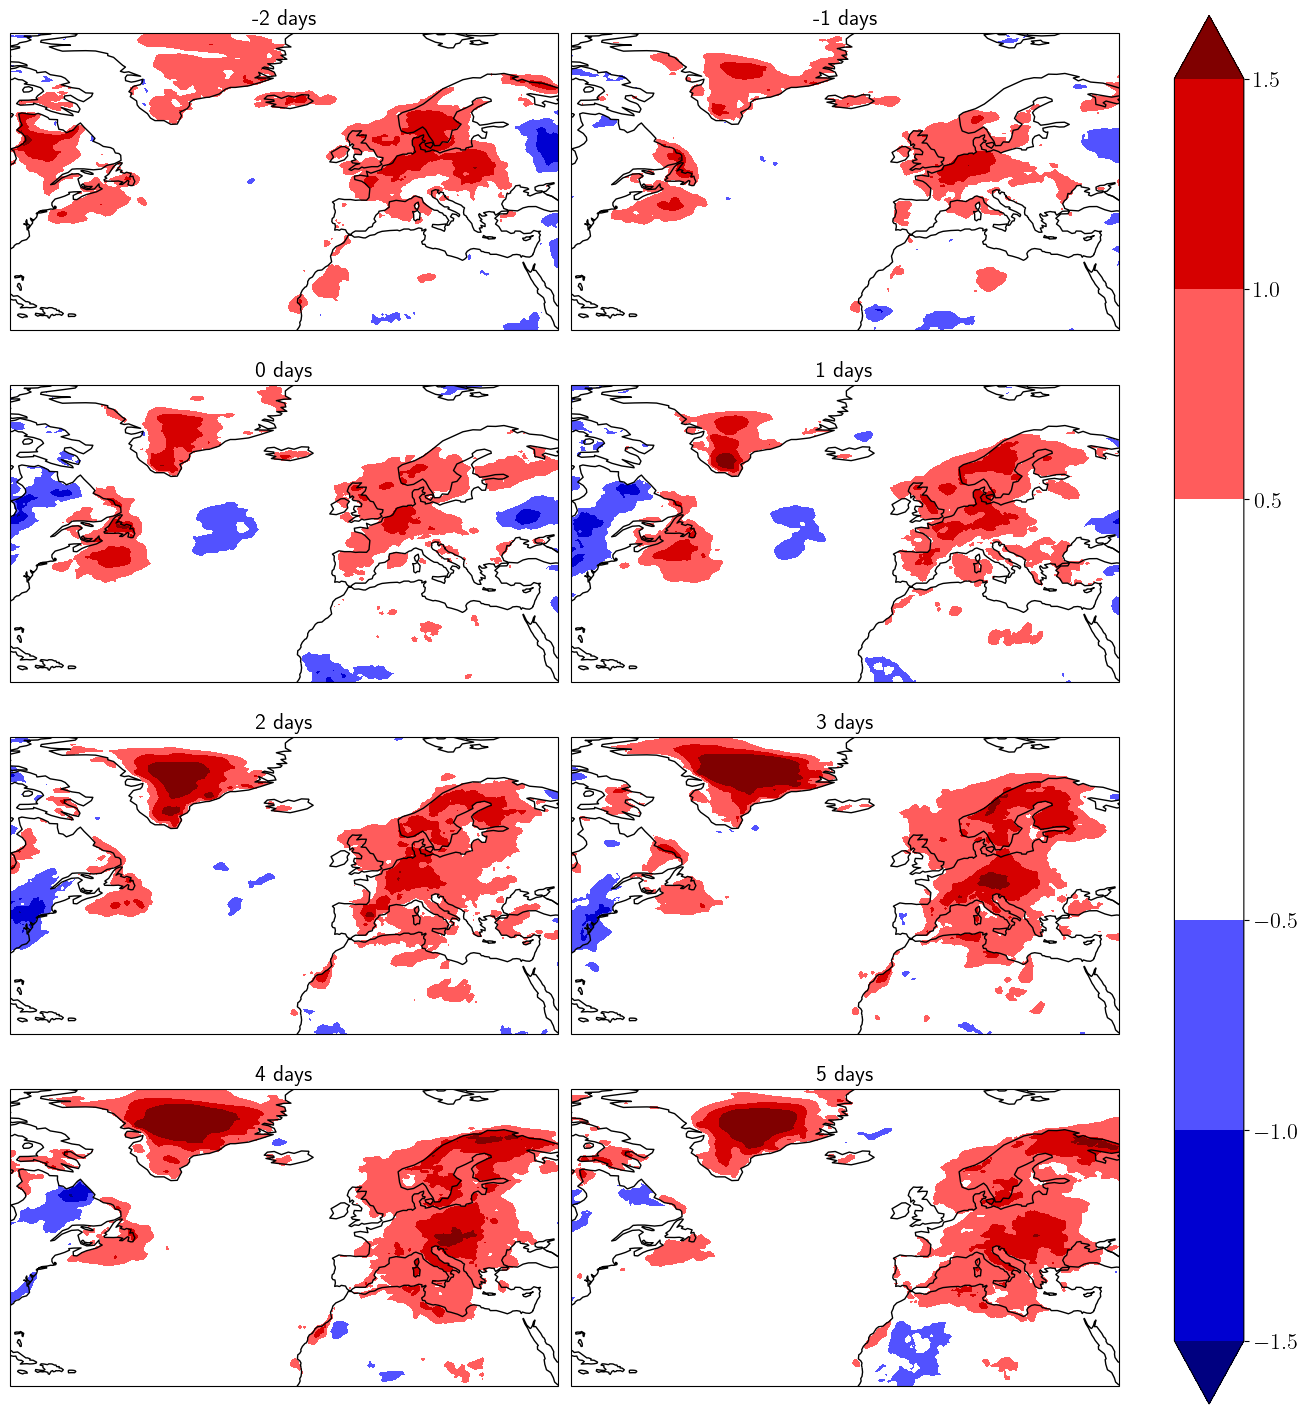

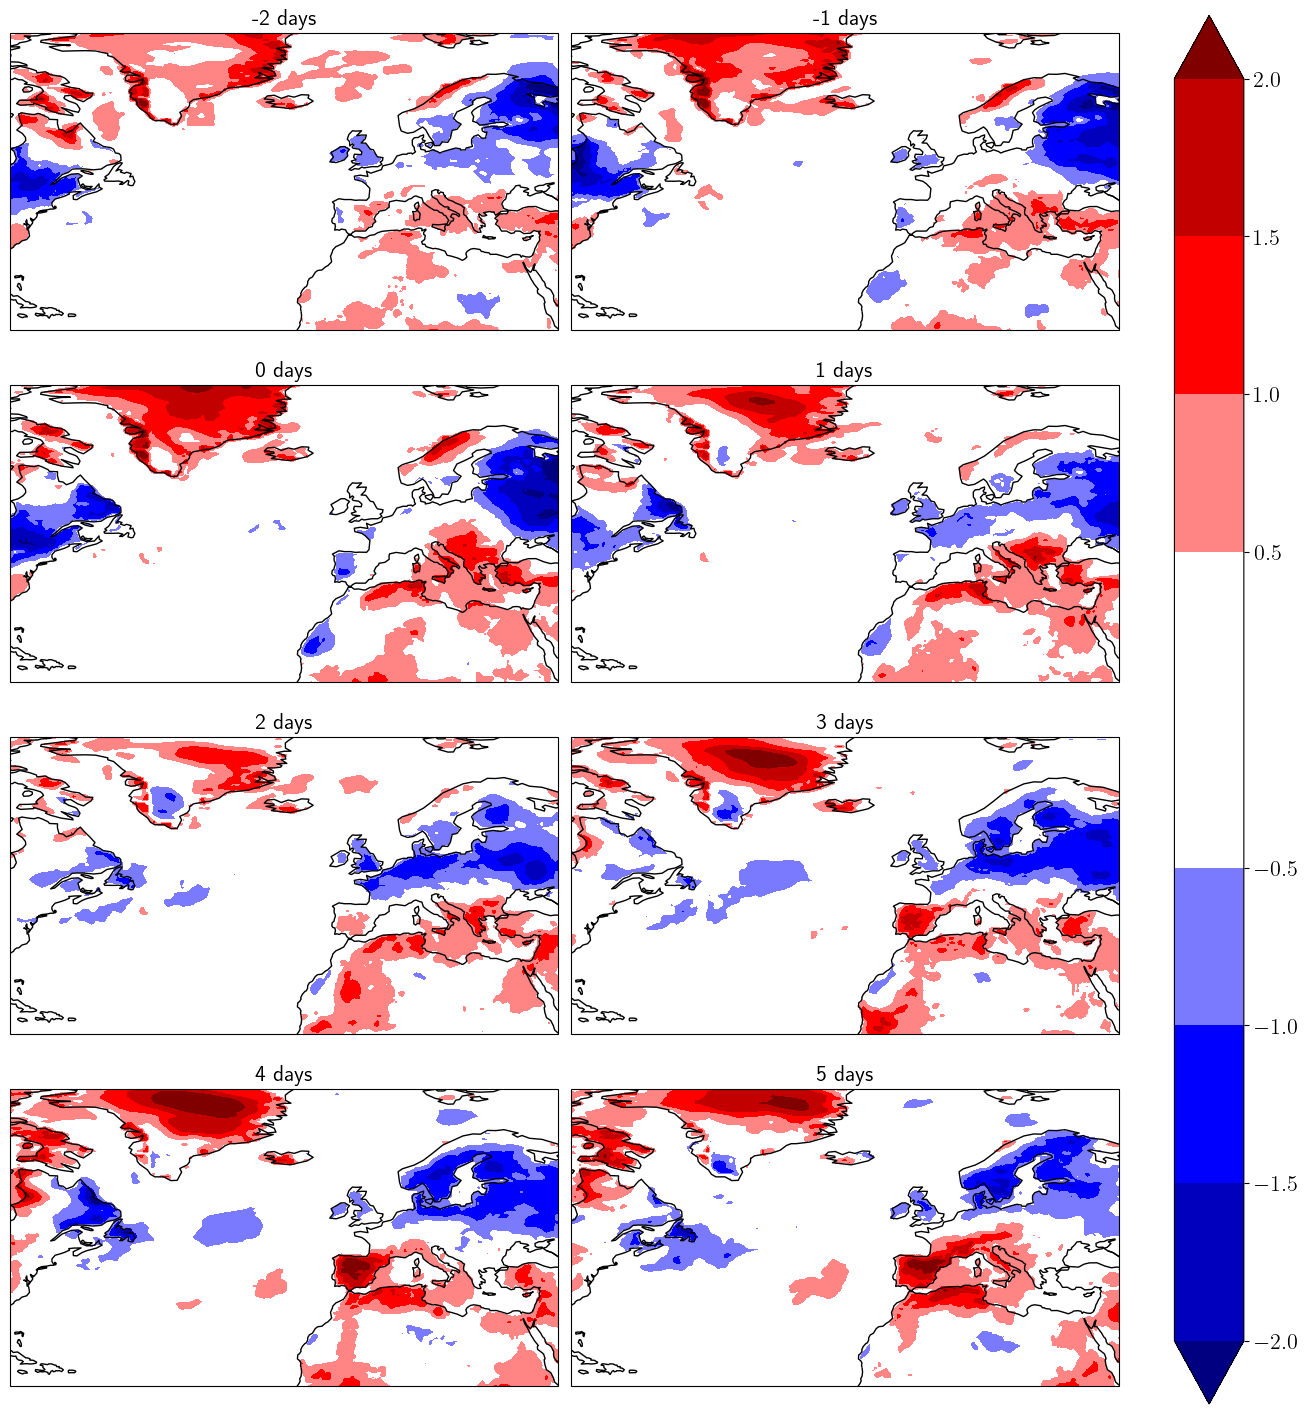

In [47]:
da = da_T.copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {"cmap": colormaps.BlWhRe, "levels": 7}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ adv. spe"]
to_plot = mask_from_spells_pl(
    spells_from_jet_daily, da, time_before=datetime.timedelta(days=4)
)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])["t2m"]
_ = clu.add_contourf(
    to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ adv. spe"]
to_plot = mask_from_spells_pl(
    spells_from_jet_daily, da, time_before=datetime.timedelta(days=4)
)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])["t2m"]
_ = clu.add_contourf(
    to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), **plot_kwargs
)

26
19


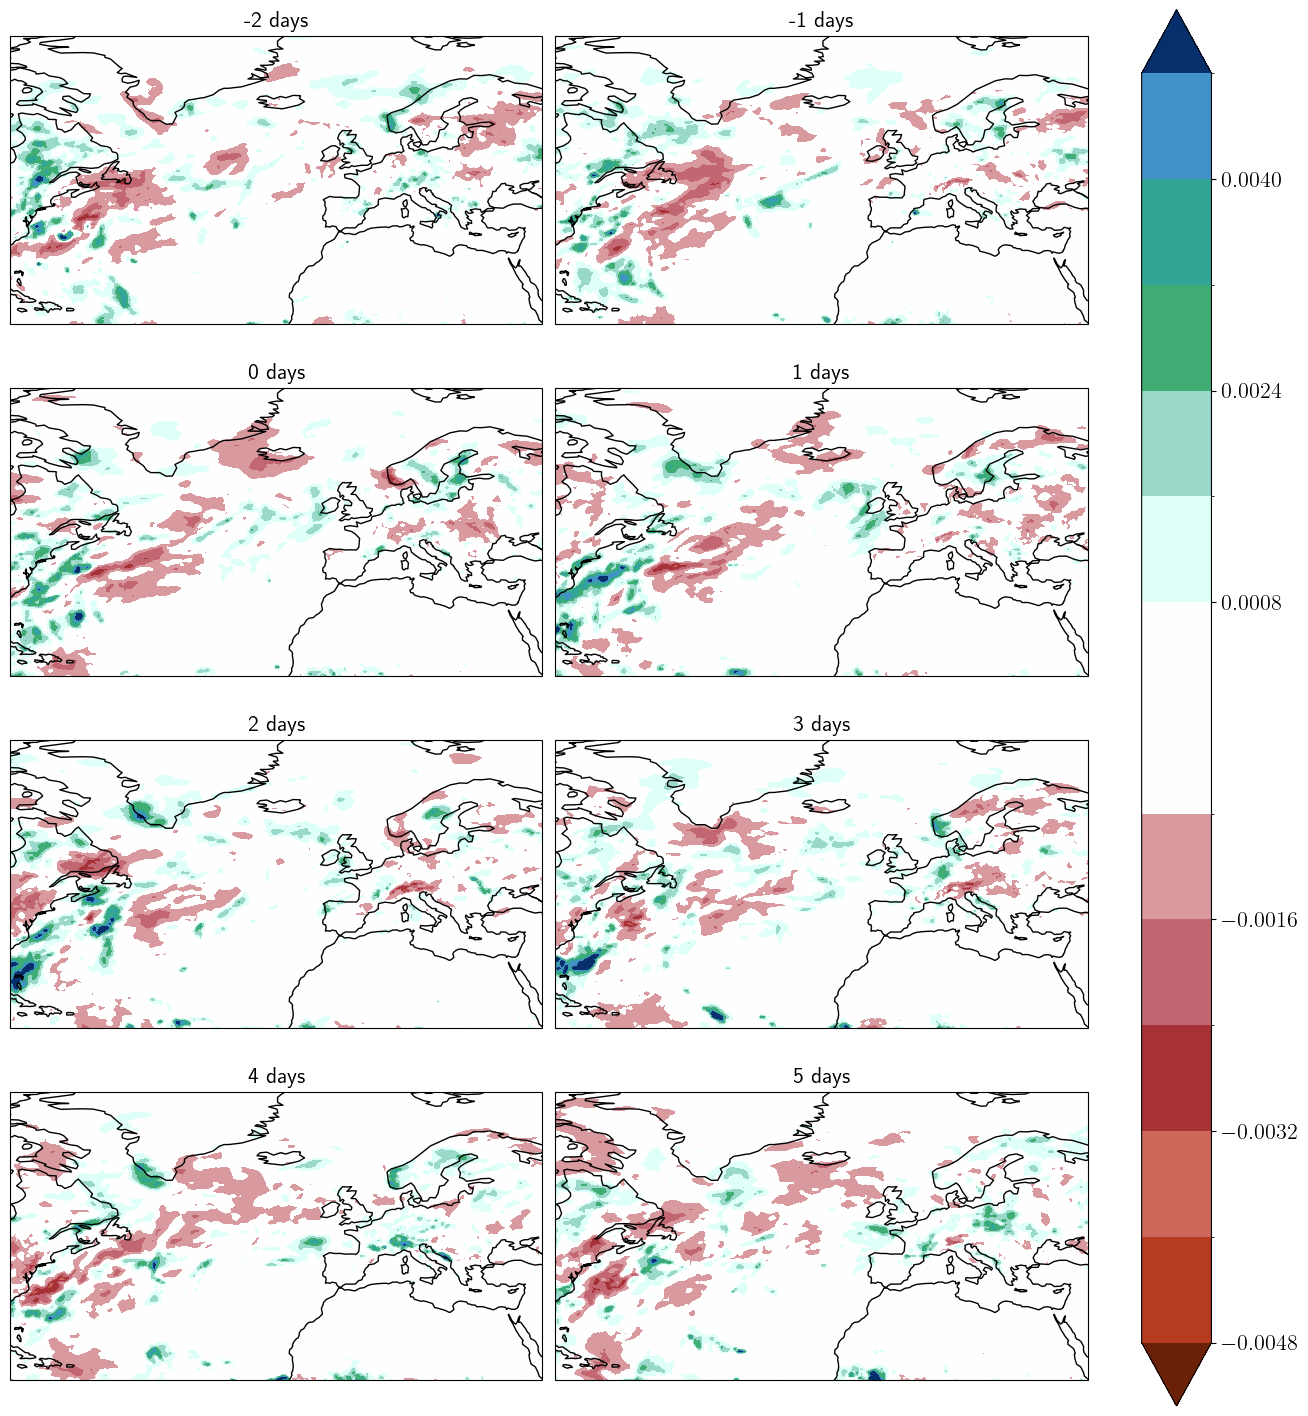

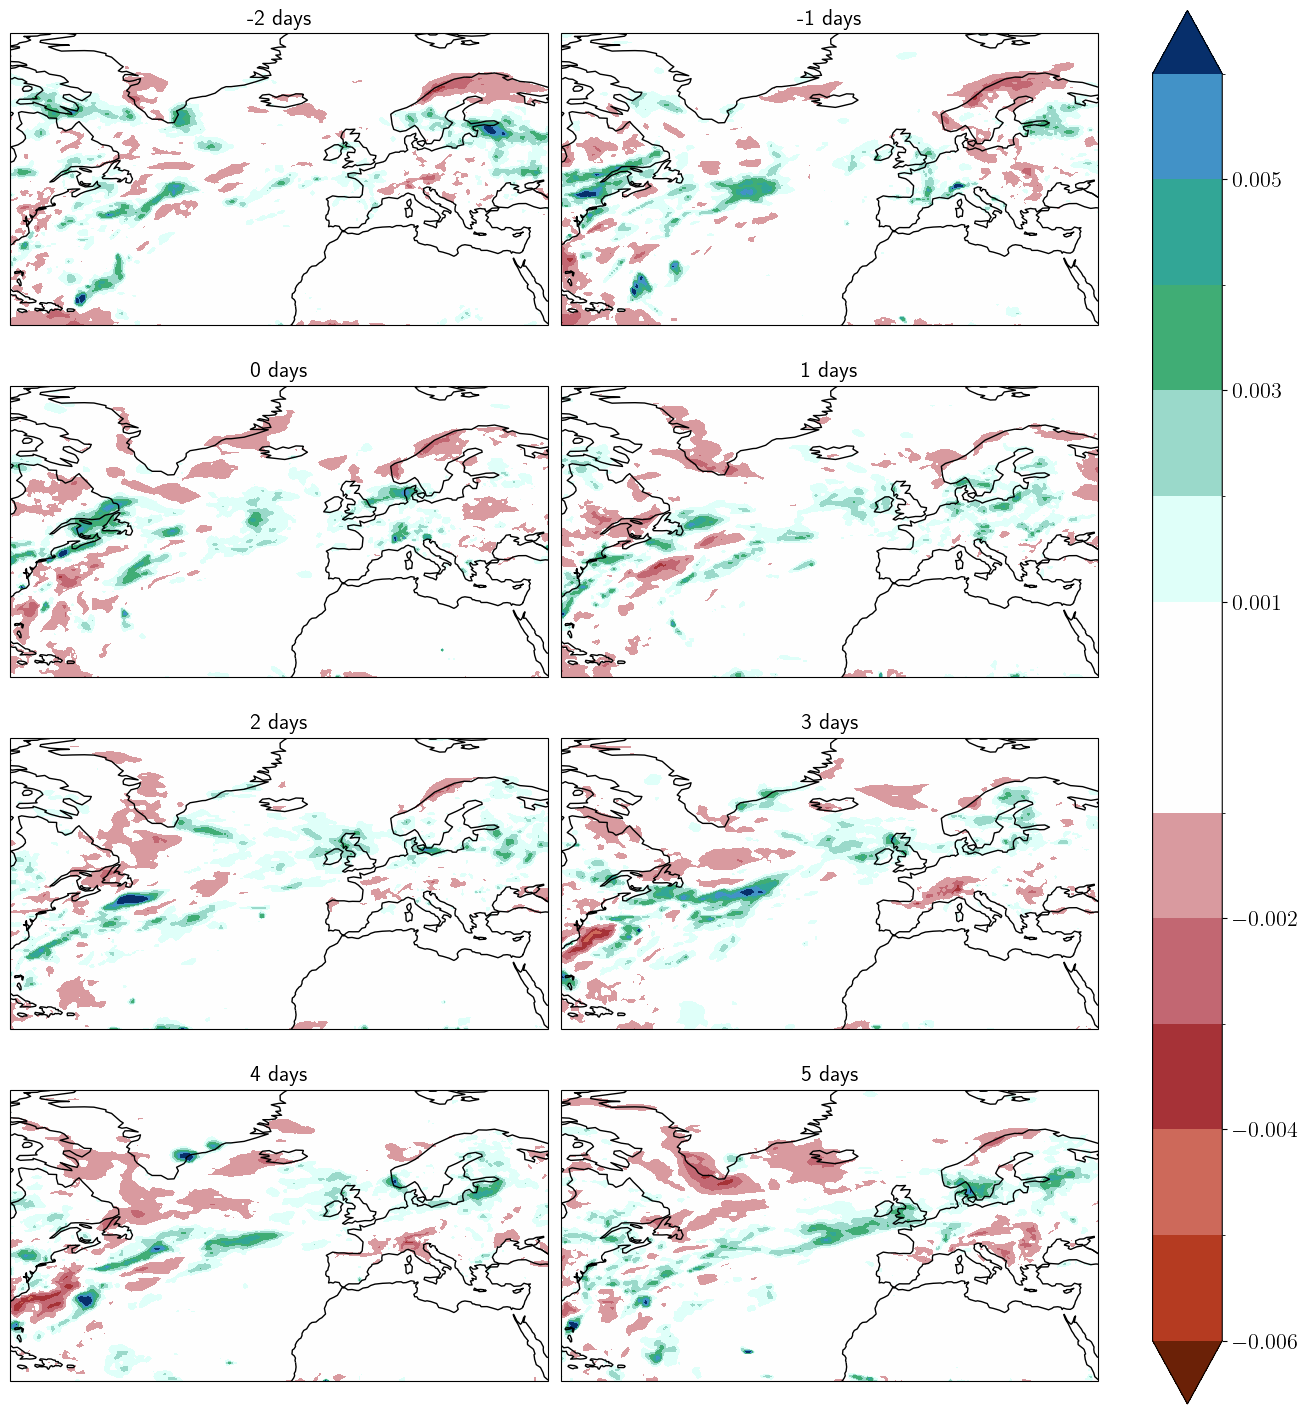

In [48]:
da = da_tp.copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": 13,
    "q": 0.999,
    "transparify": 0,
}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ adv. spe"]
to_plot = mask_from_spells_pl(
    spells_from_jet_daily, da, time_before=datetime.timedelta(days=4)
)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])["tp"]
_ = clu.add_contourf(
    to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ adv. spe"]
to_plot = mask_from_spells_pl(
    spells_from_jet_daily, da, time_before=datetime.timedelta(days=4)
)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])["tp"]
_ = clu.add_contourf(
    to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), **plot_kwargs
)

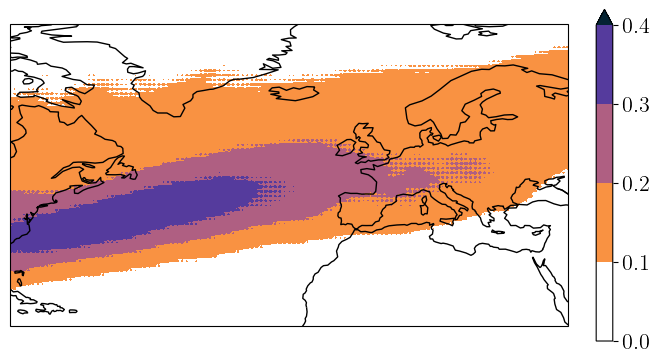

In [49]:
clu = Clusterplot(1, 1, get_region(da_apvs))
_ = clu.add_contourf(
    [compute(da_apvs.mean("time"), progress_bar=True)],
    cmap=colormaps.thermal_r,
    transparify=1,
)

In [51]:
da

<xarray.DataArray 'apvs' (time: 5888, lat: 131, lon: 241)> Size: 186MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float64 1kB 15.0 15.5 16.0 16.5 17.0 ... 78.5 79.0 79.5 80.0
  * lon      (lon) float64 2kB -80.0 -79.5 -79.0 -78.5 ... 38.5 39.0 39.5 40.0
  * time     (time) datetime64[ns] 47kB 1959-06-01 1959-06-02 ... 2022-08-31

26
19


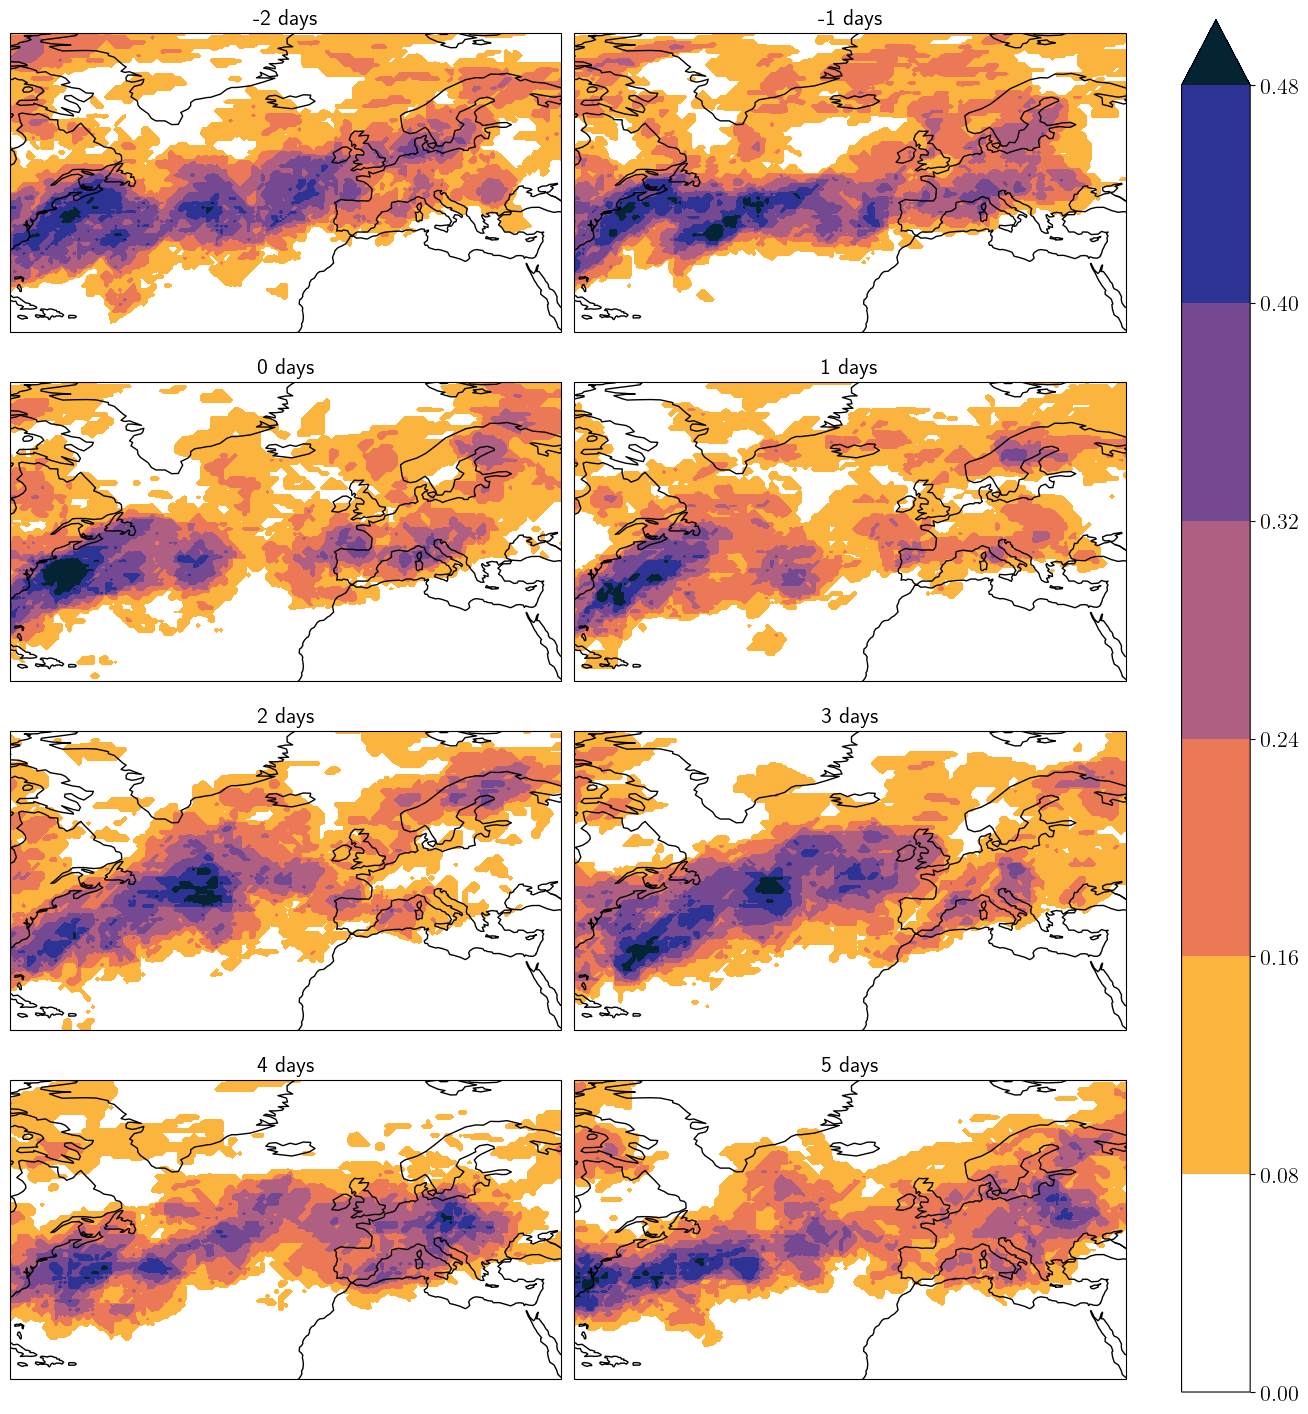

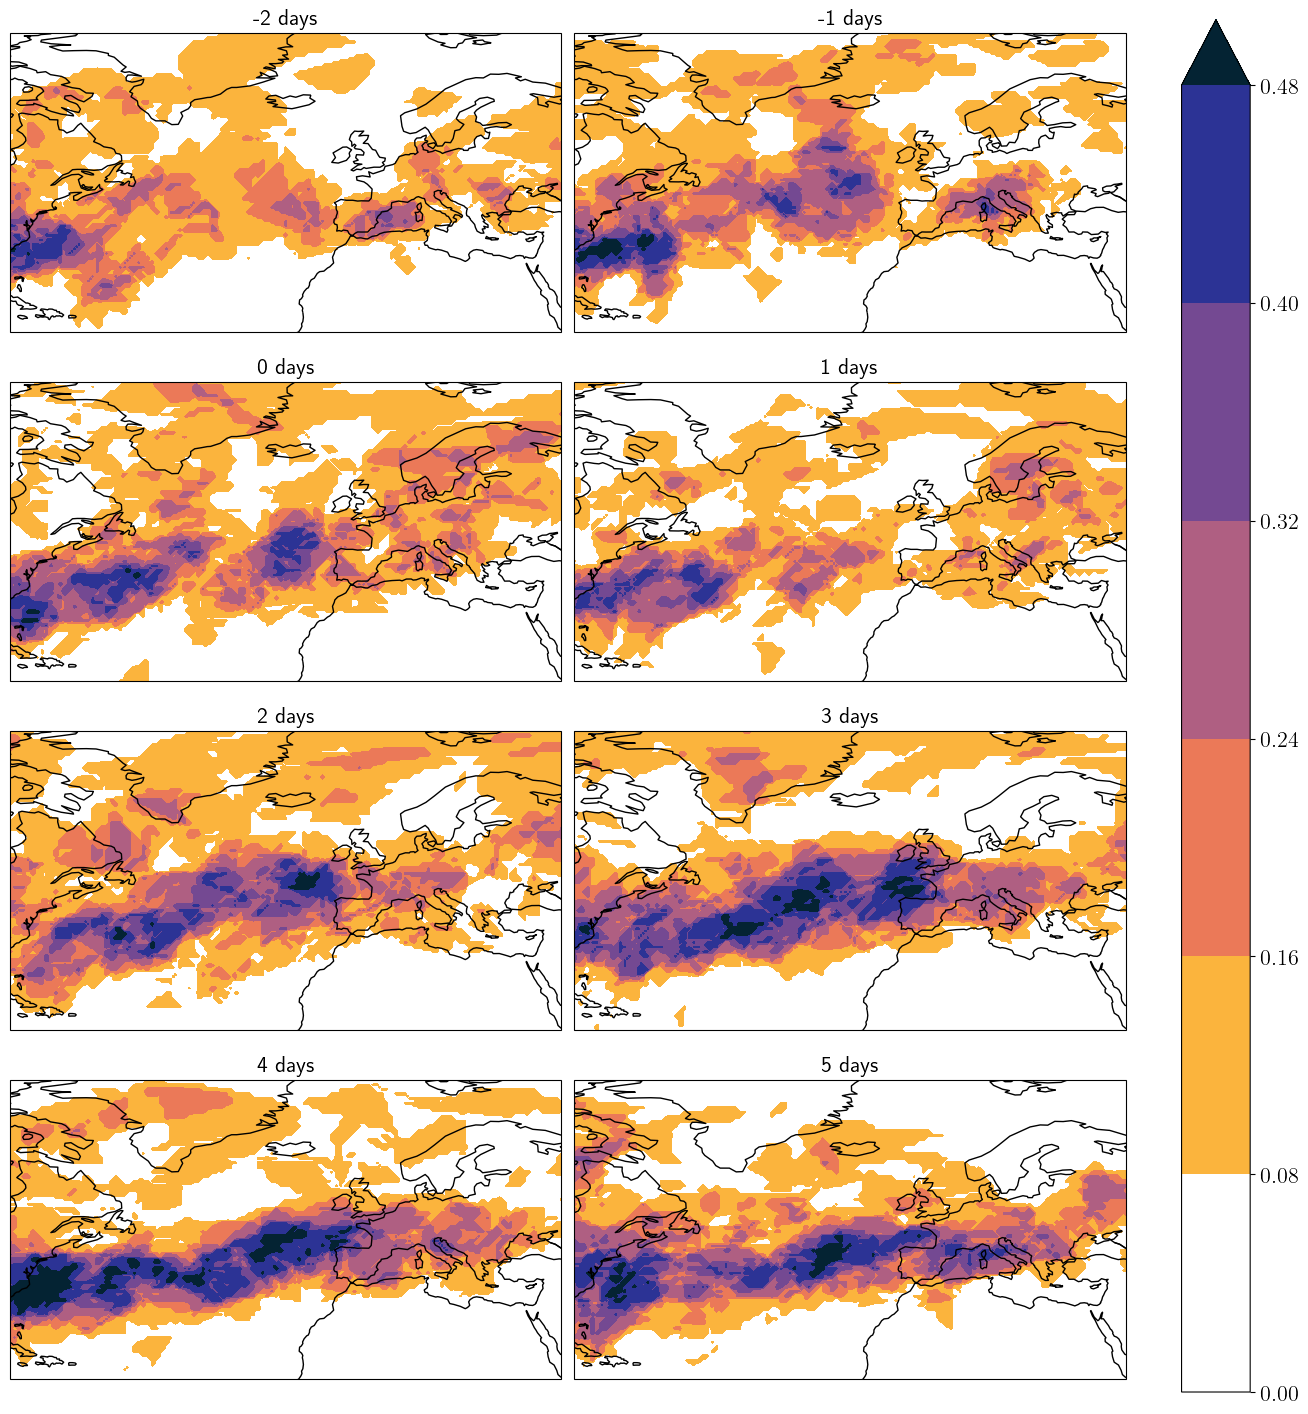

In [57]:
da = da_apvs.copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {
    "cmap": colormaps.thermal_r,
    "levels": 7,
    "transparify": 1,
}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ adv. spe"]
to_plot = mask_from_spells_pl(
    spells_from_jet_daily, da, time_before=datetime.timedelta(days=4)
)["apvs"]
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ adv. spe"]
to_plot = mask_from_spells_pl(
    spells_from_jet_daily, da, time_before=datetime.timedelta(days=4)
)["apvs"]
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), **plot_kwargs
)

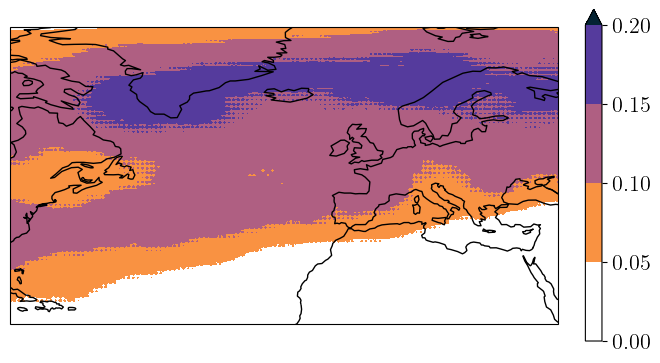

In [58]:
clu = Clusterplot(1, 1, get_region(da_cpvs))
_ = clu.add_contourf(
    [compute(da_cpvs.mean("time"), progress_bar=True)],
    cmap=colormaps.thermal_r,
    transparify=1,
)

26
19


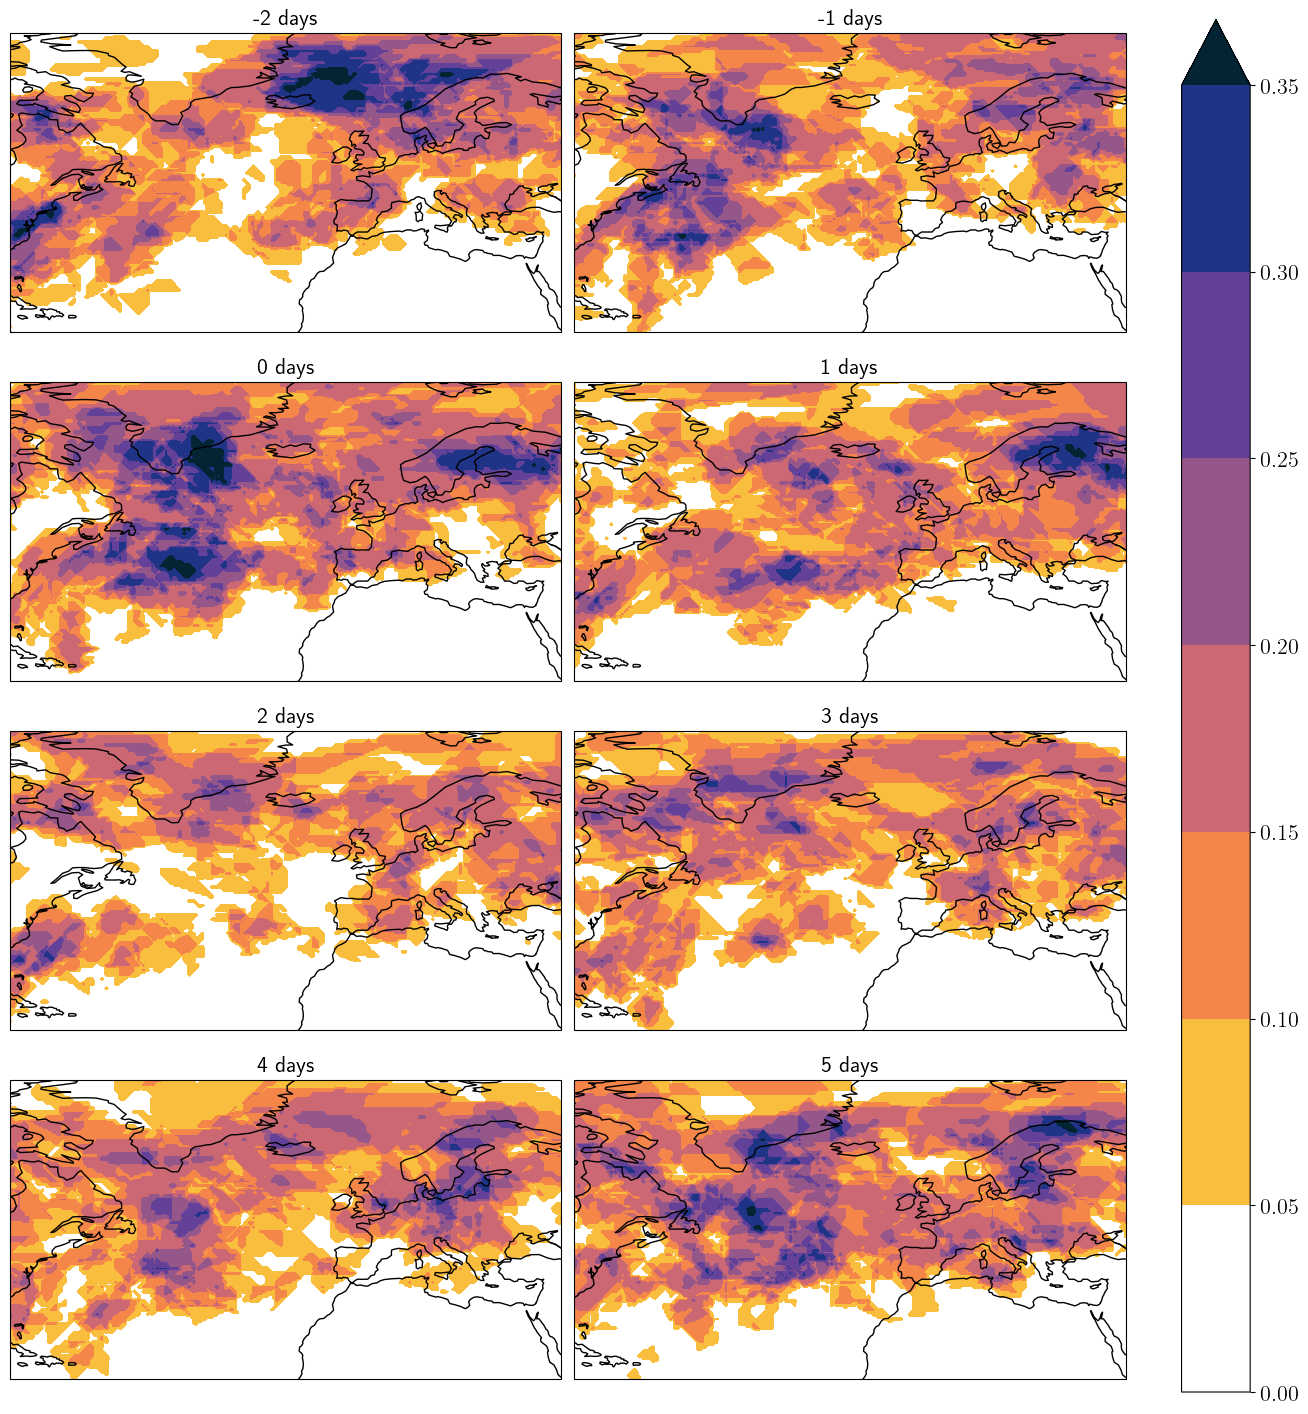

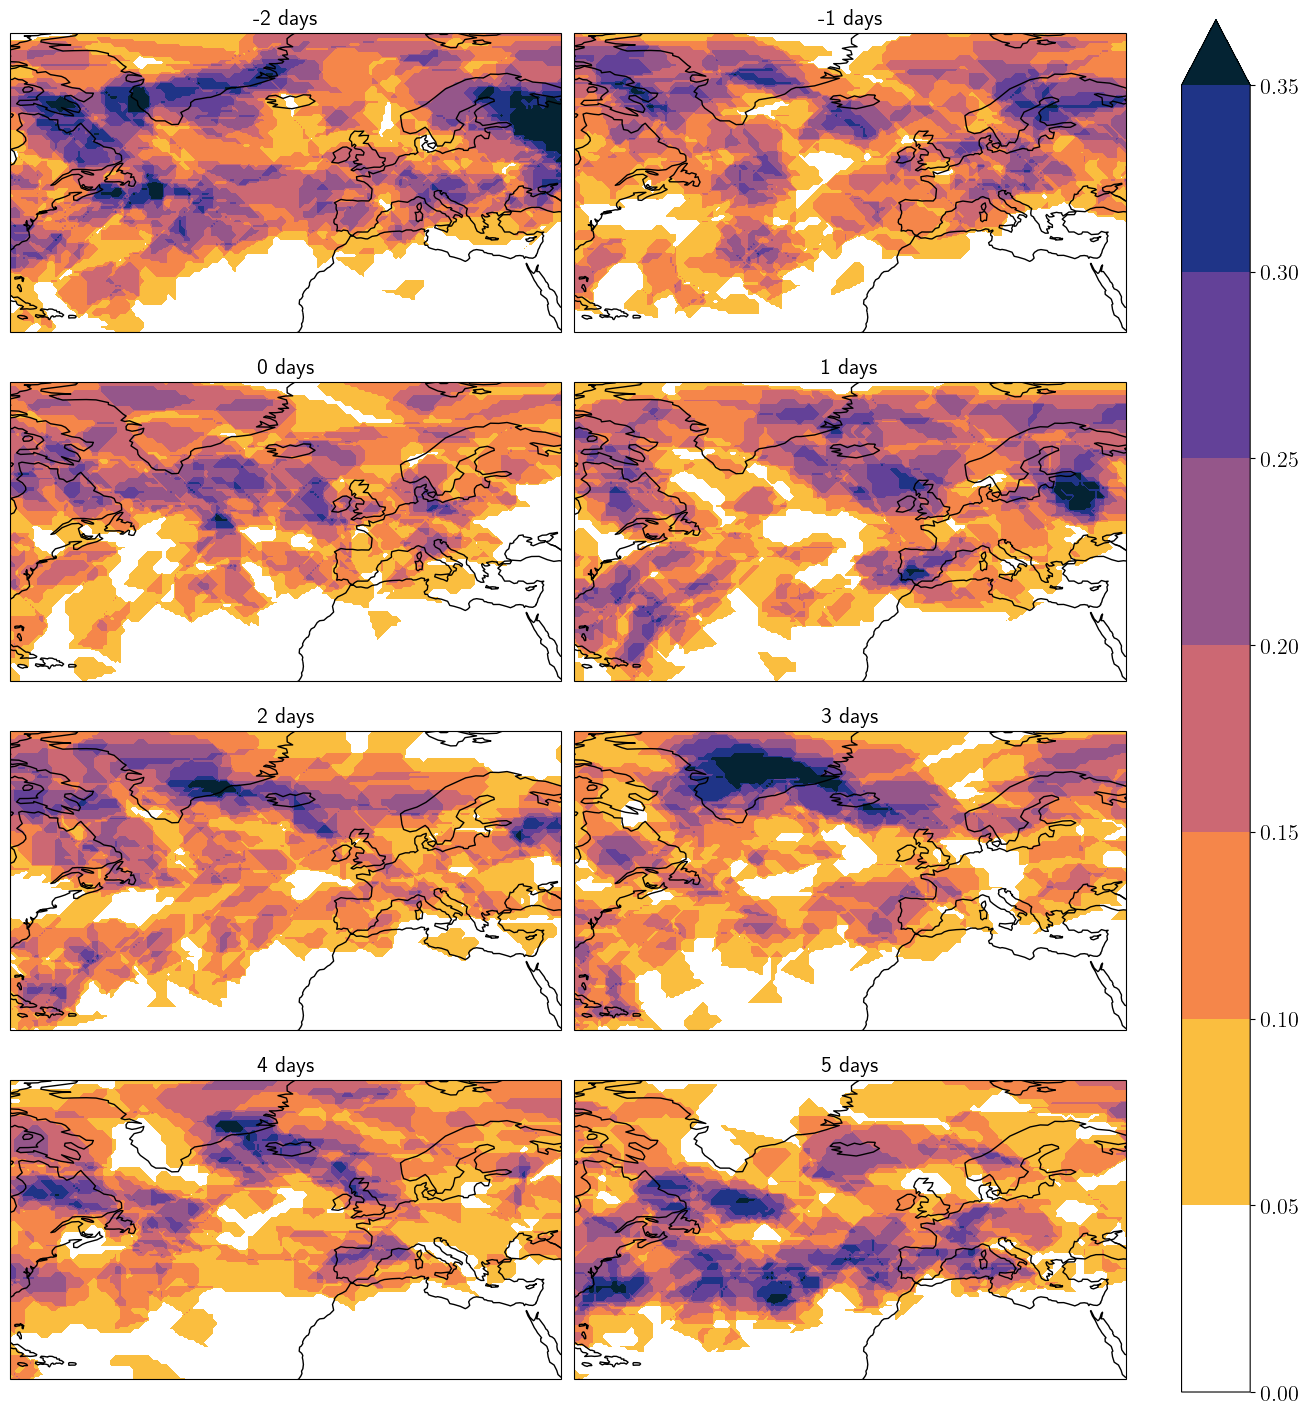

In [59]:
da = da_cpvs.copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {
    "cmap": colormaps.thermal_r,
    "levels": 7,
    "transparify": 1,
}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ adv. spe"]
to_plot = mask_from_spells_pl(
    spells_from_jet_daily, da, time_before=datetime.timedelta(days=4)
)["cpvs"]
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ adv. spe"]
to_plot = mask_from_spells_pl(
    spells_from_jet_daily, da, time_before=datetime.timedelta(days=4)
)["cpvs"]
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), **plot_kwargs
)